# Technical Assessment (Further Tests)

## Initial Setup

In [1]:
# Load packages.
import sys
import scipy
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from prettytable import PrettyTable

from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.metrics import (make_scorer, 
                             matthews_corrcoef,
                             accuracy_score, 
                             balanced_accuracy_score,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             roc_auc_score, 
                             roc_curve,
                             jaccard_score, 
                             precision_recall_curve,
                             auc,
                             confusion_matrix) 

# Without warning messages.
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPU architecture:"
!echo "$(lscpu)"
!echo "RAM memory:"
!echo "$(free -gt)"


>>> Computer:
* Hostname: n007
* User: sandroal
* Directory: /work/sandroal/notebooks/data_science/datalab
* Date: Tue Apr 13 13:49:15 BRT 2021
* CPU architecture:
Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                40
On-line CPU(s) list:   0-39
Thread(s) per core:    2
Core(s) per socket:    10
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 62
Stepping:              4
CPU MHz:               1200.000
BogoMIPS:              4988.39
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              25600K
NUMA node0 CPU(s):     0-9,20-29
NUMA node1 CPU(s):     10-19,30-39
RAM memory:
             total       used       free     shared    buffers     cached
Mem:            62         27         35          0          0         26
-/+ buffers/cache:          1   

In [3]:
# Intercomparison of models.
models = {}
results = {}

# All intersting scores for comparing models.
def all_scores(model, X_true, y_true):
    
    # Fraudulent is class 1.
    y_score = model.predict_proba(X_true)[:, 1]
    y_pred = model.predict(X_true)
    
    # Area under the precision-recall curve PR AUC.
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    
    # Classification metrics.
    mat = matthews_corrcoef(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    bac = balanced_accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1s = f1_score(y_true, y_pred, zero_division=0) 
    AUC = roc_auc_score(y_true, y_score)
    pra = auc(recall, precision)
    jac = jaccard_score(y_true, y_pred)
    scores = (mat, acc, bac, pre, rec, f1s, AUC, pra, jac)

    return scores
    
# Precision-recall receiver operating characteristic (PR ROC) curve.
def plot_pr_roc(model, X_true, y_true, model_name="model"):
   
    # Fraudulent is class 1.
    y_score = model.predict_proba(X_true)[:, 1]
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    
    # No skill.
    dummy_classifier = DummyClassifier(strategy="most_frequent")
    dummy_classifier.fit(X_true, y_true)
    y_score_ns = dummy_classifier.predict_proba(X_true)[:, 1]
    precision_ns, recall_ns, _ = precision_recall_curve(y_true, y_score_ns)
    
    # Make figure.
    plt.figure(figsize=(7.5 * 1.25, 5 * 1.25))
    plt.plot(recall, precision, label="This Model", color="blue", lw=1.5)
    plt.plot(recall_ns, precision_ns, lw=1.5, ls="--", color="red", label="No Skill - Most Frequent Class")
    plt.xticks(ticks=np.arange(0, 1.1, 0.1))
    plt.yticks(ticks=np.arange(0, 1.1, 0.1))
    plt.title(
        model_name + "\n" + \
        "Precision-Recall Curve\n",
        weight="bold"
    )
    plt.xlabel("Recall", weight="bold")
    plt.ylabel("Precision", weight="bold")
    plt.legend()
    plt.grid()

# Confusion matrix.
def plot_confusion_matrix(model, X_true, y_true, model_name="model"):   
    
    # Predicted class and confusion matrix.
    y_pred = model.predict(X_true)
    C = confusion_matrix(y_true, y_pred, labels=[1, 0])
    df_C = pd.DataFrame(data=C, index=["Fraudulent", "Valid"], columns=["Fraudulent", "Valid"]).T
    scores = all_scores(model, X_true, y_true)
    
    # Make figure.
    plt.figure(figsize=(7.5 * 1.25, 5 * 1.25))
    
    # Confusion matrix.
    ax = sns.heatmap(
        data=df_C, 
        annot=True, 
        cmap=plt.cm.Greens_r, 
        fmt="d", 
        linecolor="black",
        linewidths=2,
        annot_kws={"weight": "bold", "size": 16},
        cbar_kws={"extend": "both", "pad": 0.015},
        ax=plt.gca()
    )
    
    # Text with results for classification metrics.
    text = \
    """
    Classification scores:  
    
    %.4f  -  Matthews
    %.4f  -  Accuracy          
    %.4f  -  Bal. Accuracy 
    %.4f  -  Precision     
    %.4f  -  Recall 
    %.4f  -  F1 score         
    %.4f  -  AUC   
    %.4f  -  PR AUC   
    %.4f  -  Jaccard      
    """ %(scores)
    
    ax.collections[0].axes.text(
        x=1.18, y=0.35, s=text, weight="bold", transform=plt.gca().transAxes
    )
        
    # Adjustments.
    plt.gcf().suptitle(model_name, weight="bold")
    ax.set_title("Confusion matrix", weight="bold")
    ax.set_xlabel(" ---------------------- TRUE ----------------------- ", weight="bold")
    ax.set_ylabel(" -------------------- PREDICTED -------------------- ", weight="bold")
    ax.collections[0].colorbar.set_label("Counts", weight="bold")
    ax.collections[0].axes.set_xticklabels(df_C.columns, weight="bold")
    ax.collections[0].axes.set_yticklabels(df_C.index, weight="bold")
    ax.collections[0].colorbar.outline.set_edgecolor("black")
    ax.collections[0].colorbar.outline.set_linewidth(2)
    
# Save PrettyTable results to a CSV file.    
def ptable_to_csv(table, filename, headers=True):
    """Save PrettyTable results to a CSV file.

    Adapted from @AdamSmith https://stackoverflow.com/questions/32128226

    :param PrettyTable table: Table object to get data from.
    :param str filename: Filepath for the output CSV.
    :param bool headers: Whether to include the header row in the CSV.
    :return: None
    """
    raw = table.get_string()
    data = [tuple(filter(None, map(str.strip, splitline)))
            for line in raw.splitlines()
            for splitline in [line.split('|')] if len(splitline) > 1]
    if table.title is not None:
        data = data[1:]
    if not headers:
        data = data[1:]
    with open(filename, 'w') as f:
        for d in data:
            f.write('{}\n'.format(','.join(d)))    

## Exploratory Data Analysis

In [4]:
# As a pandas DataFrame object.
df = pd.read_csv("./creditcard.csv")

# Sizes.
shape_original = df.shape
print(">>> Original data shape:", shape_original)

# Without duplicated instances.
df.drop_duplicates(inplace=True)
print(">>> How many duplicated instances?:", shape_original[0] - df.shape[0])

# Missing data.
print(">>> How many NaNs?:", df.isnull().sum().sum())

# Understanding data structure.
print(">>> Information:")
print(df.info())

>>> Original data shape: (284807, 31)
>>> How many duplicated instances?: 1081
>>> How many NaNs?: 0
>>> Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18   

In [5]:
# Data head.
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# High unbalanced data! 
# Class: 1 means fraudulent transaction and 0 is valid transaction.
df_tmp = pd.concat(
    objs=[df["Class"].value_counts(), df["Class"].value_counts(normalize=True) * 100],
    axis=1,
    keys=["Counts","Percentage"]
)
df_tmp.insert(loc=0, column="Fraudulent", value=[False, True])
df_tmp.insert(loc=0, column="Class", value=[0, 1])
df_tmp.set_index(["Class"], inplace=True)
df_tmp

,Fraudulent,Counts,Percentage
Class,,,
0,False,283253,99.83329
1,True,473,0.16671


In [7]:
# New order for features.
new = ["Time", "Amount"] + [feature for feature in df.columns if "V" in feature] + ["Class"]
df = df[new]

# Names.
features = df.columns.drop("Class")
target = "Class"

CPU times: user 892 ms, sys: 48 ms, total: 940 ms
Wall time: 942 ms


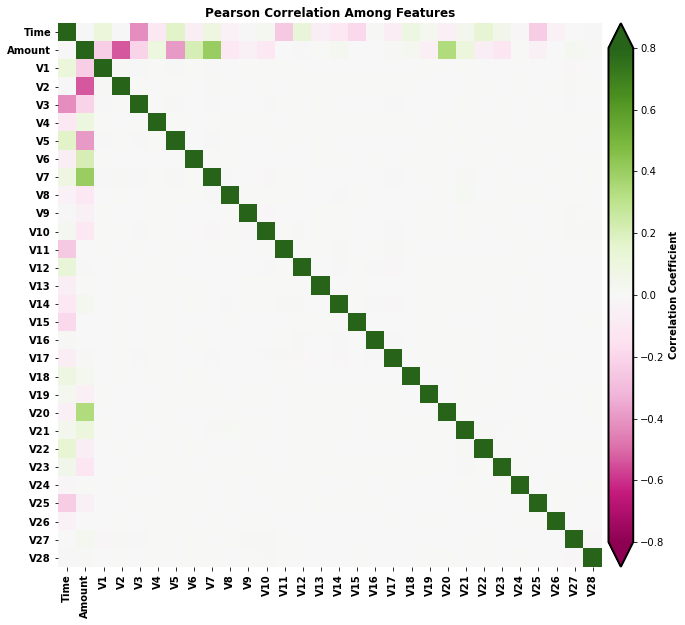

In [8]:
%%time

# Pearson correlation.
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    data=df.drop([target], axis="columns").corr(method="pearson"),
    vmin=-0.80, 
    vmax=0.80, 
    square=True,
    cmap=plt.cm.PiYG,
    cbar_kws={"extend": "both", "pad": 0.01}
)

# Adjustments.
ax.set_xticklabels(ax.get_xticklabels(), weight="bold", rotation="vertical")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Correlation Coefficient", weight="bold")
ax.set_title("Pearson Correlation Among Features", weight="bold")
ax.collections[0].colorbar.outline.set_edgecolor("black")
_ = ax.collections[0].colorbar.outline.set_linewidth(2)

CPU times: user 4min 52s, sys: 1.35 s, total: 4min 54s
Wall time: 4min 54s


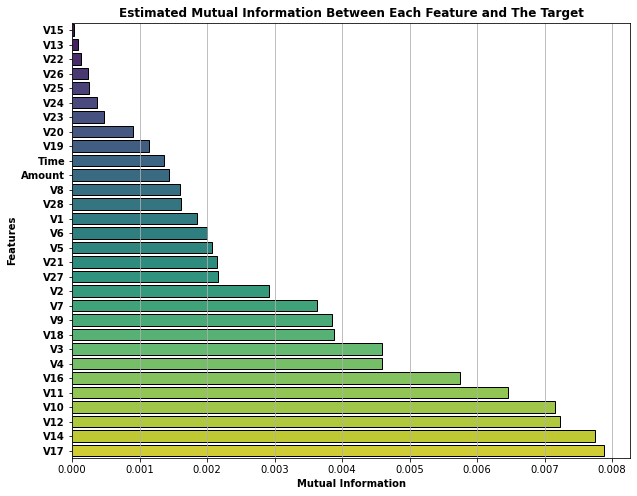

In [9]:
%%time

# Mutual information between continuous features and discrete target.
# These values will be used for feature selection in random forest model.
mi = mutual_info_classif(
    X=df[features],
    y=df[target],
    n_neighbors=3,
    discrete_features=False
)

# Features in ascending order of mutual information intensity with target.
plt.figure(figsize=(10, 8))
asc_order = mi.argsort()
mi_ordered = pd.Series(data=mi[asc_order], index=features[asc_order])
ax = sns.barplot(
    y=mi_ordered.index, 
    x=mi_ordered.values,
    orient="h",
    palette=sns.color_palette("viridis", n_colors=len(mi_ordered)),
    edgecolor="black"
)

# Adjustments.
ax.set_xlabel("Mutual Information", weight="bold")
ax.set_ylabel("Features", weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.set_title("Estimated Mutual Information Between Each Feature and The Target", 
             weight="bold")
_ = ax.grid(axis="x")

In [10]:
%%time

mis = []
for n_neighbors in [3, 4, 5, 8, 10]:
    print(f">>> Calculating for parameter {n_neighbors} ...")
    
    mi = mutual_info_classif(
        X=df[features],
        y=df[target],
        n_neighbors=n_neighbors,
        discrete_features=False
    )
    
    mi_series = pd.Series(data=mi, index=features)
    
    mis.append(mi_series)

>>> Calculating for parameter 3 ...
>>> Calculating for parameter 4 ...
>>> Calculating for parameter 5 ...
>>> Calculating for parameter 8 ...
>>> Calculating for parameter 10 ...
CPU times: user 24min 37s, sys: 7.55 s, total: 24min 44s
Wall time: 24min 46s


CPU times: user 268 ms, sys: 20 ms, total: 288 ms
Wall time: 286 ms


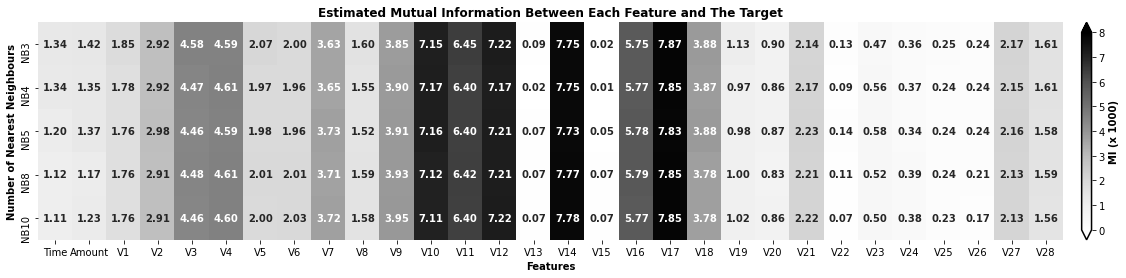

In [11]:
%%time

df_mi = pd.concat(objs=mis, axis="columns")
df_mi.columns = ["NB3", "NB4", "NB5", "NB8", "NB10"]

plt.figure(figsize=(22, 4))
scale = 1000
ax = sns.heatmap(
    data=df_mi.T * scale, 
    cmap=plt.cm.Greys, 
    vmin=0, 
    vmax=8,
    annot=True,
    fmt=".2f",
    annot_kws={"weight": "bold", "size": 10},
    cbar_kws={"extend": "both", "pad": 0.015},
)
ax.set_title("Estimated Mutual Information Between Each Feature and The Target", 
             weight="bold")
ax.set_xlabel("Features", weight="bold")
ax.set_ylabel("Number of Nearest Neighbours", weight="bold")
ax.collections[0].colorbar.outline.set_edgecolor("black")
ax.collections[0].colorbar.outline.set_linewidth(1.5)
ax.collections[0].colorbar.set_label(f"MI (x {scale})", weight="bold")

CPU times: user 204 ms, sys: 20 ms, total: 224 ms
Wall time: 223 ms


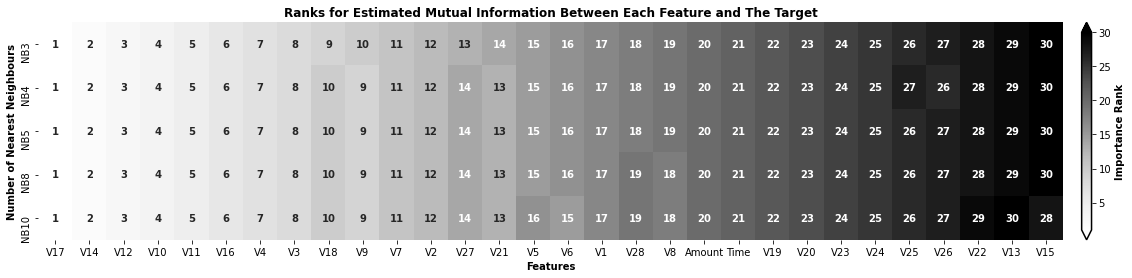

In [12]:
%%time

df_mi_ranks = pd.DataFrame(
    data=scipy.stats.rankdata((-1) * df_mi.values, axis=0),
    index=df_mi.index,
    columns=df_mi.columns
)

df_mi_ranks = df_mi_ranks.sort_values(
    by="NB3", 
    axis="index", 
    ascending=True, 
    inplace=False
)

plt.figure(figsize=(22, 4))
ax = sns.heatmap(
    data=df_mi_ranks.T, 
    cmap=plt.cm.Greys, 
    vmin=1, 
    vmax=30,
    annot=True,
    annot_kws={"weight": "bold", "size": 10},
    cbar_kws={"extend": "both", "pad": 0.015},
)
ax.set_title("Ranks for Estimated Mutual Information Between Each Feature and The Target", 
             weight="bold")
ax.set_xlabel("Features", weight="bold")
ax.set_ylabel("Number of Nearest Neighbours", weight="bold")
ax.collections[0].colorbar.outline.set_edgecolor("black")
ax.collections[0].colorbar.outline.set_linewidth(1.5)
ax.collections[0].colorbar.set_label(f"Importance Rank", weight="bold")

CPU times: user 5.1 s, sys: 36 ms, total: 5.14 s
Wall time: 5.15 s


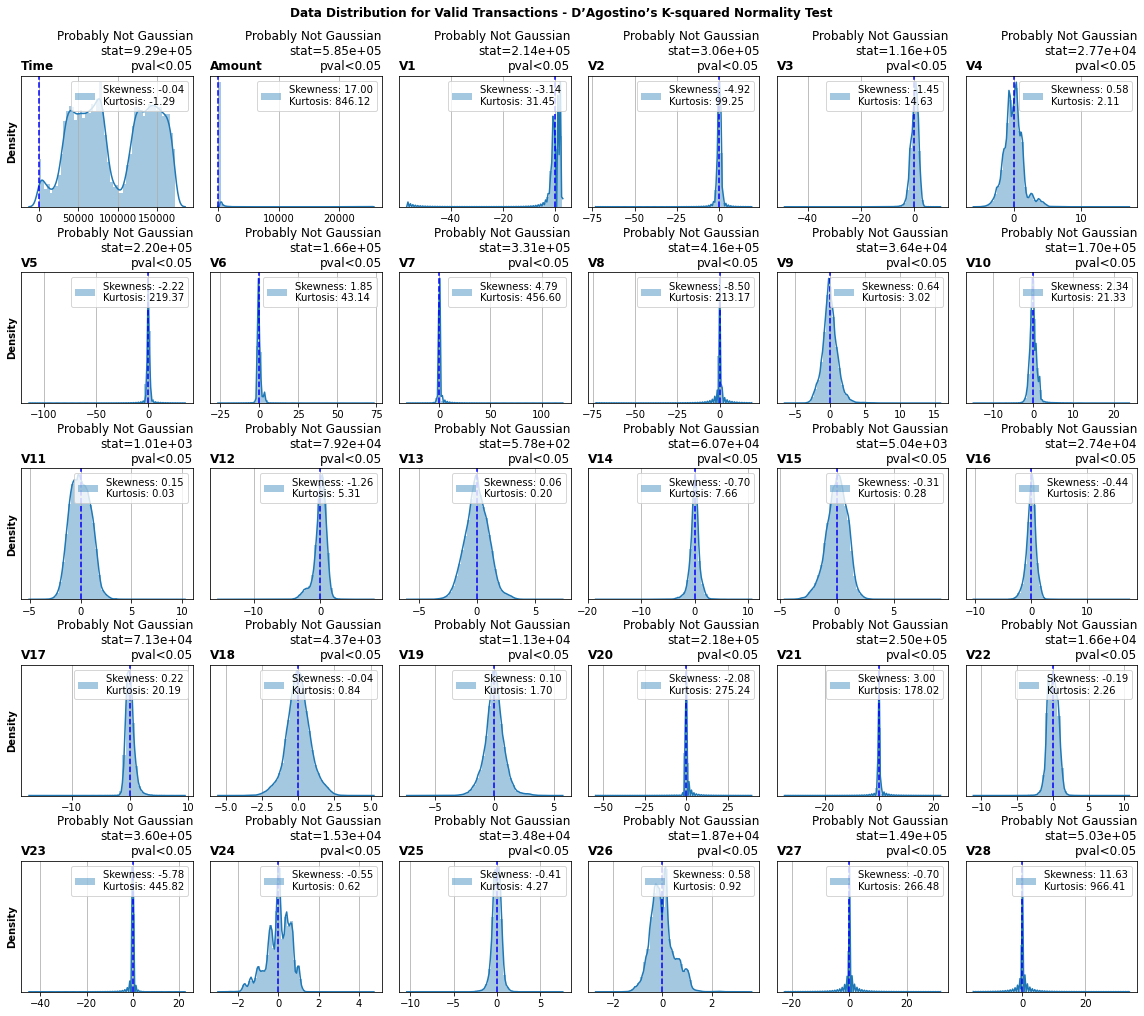

In [13]:
%%time

# Make figure and axes.
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 16))
axes = axes.flatten()

# Only valid transactions.
valid = df[target] == 0
df_tmp = df[valid]

# Plot distribution for each feature.
for axis, feature in zip(axes, features):

    data = df_tmp[feature]
    
    # Skweness and kurtosis for this feature.
    skew = scipy.stats.skew(data)
    kurtosis = scipy.stats.kurtosis(data, fisher=True)
    label = "Skewness: %.2f\nKurtosis: %.2f" %(skew, kurtosis)
    
    plotdata = sns.distplot(
        a=data,
        ax=axis,
        norm_hist=True,
        label=label
    )
    axis.axvline(ls="--", color="blue")    
    
    # Do data have a Gaussian distribution? D’Agostino’s K-squared test.
    statistic, pvalue = scipy.stats.normaltest(data)
    
    if pvalue > 0.05: # The null hypothesis CANNOT be rejected
        text = "Probably Gaussian\nstat=%.2e\npval>0.05" %(statistic)
    
    else:             # The null hypothesis CAN be rejected.  
        text = "Probably Not Gaussian\nstat=%.2e\npval<0.05" %(statistic)
    
    # Adjustments. 
    axis.legend(loc="upper right")
    axis.set_yticks([])
    axis.set_title(feature, loc="left", weight="bold")
    axis.set_title(text, loc="right")
    plotdata.set_xlabel(None)
    plotdata.grid()
    
# More adjustments.
axes[0].set_ylabel("Density", weight="bold")
axes[6].set_ylabel("Density", weight="bold")
axes[12].set_ylabel("Density", weight="bold")
axes[18].set_ylabel("Density", weight="bold")
axes[24].set_ylabel("Density", weight="bold")
plt.suptitle("Data Distribution for Valid Transactions - D’Agostino’s K-squared Normality Test",
             weight="bold")
plt.subplots_adjust(wspace=0.10, hspace=0.50, top=0.92)

del data

CPU times: user 1.62 s, sys: 8 ms, total: 1.63 s
Wall time: 1.63 s


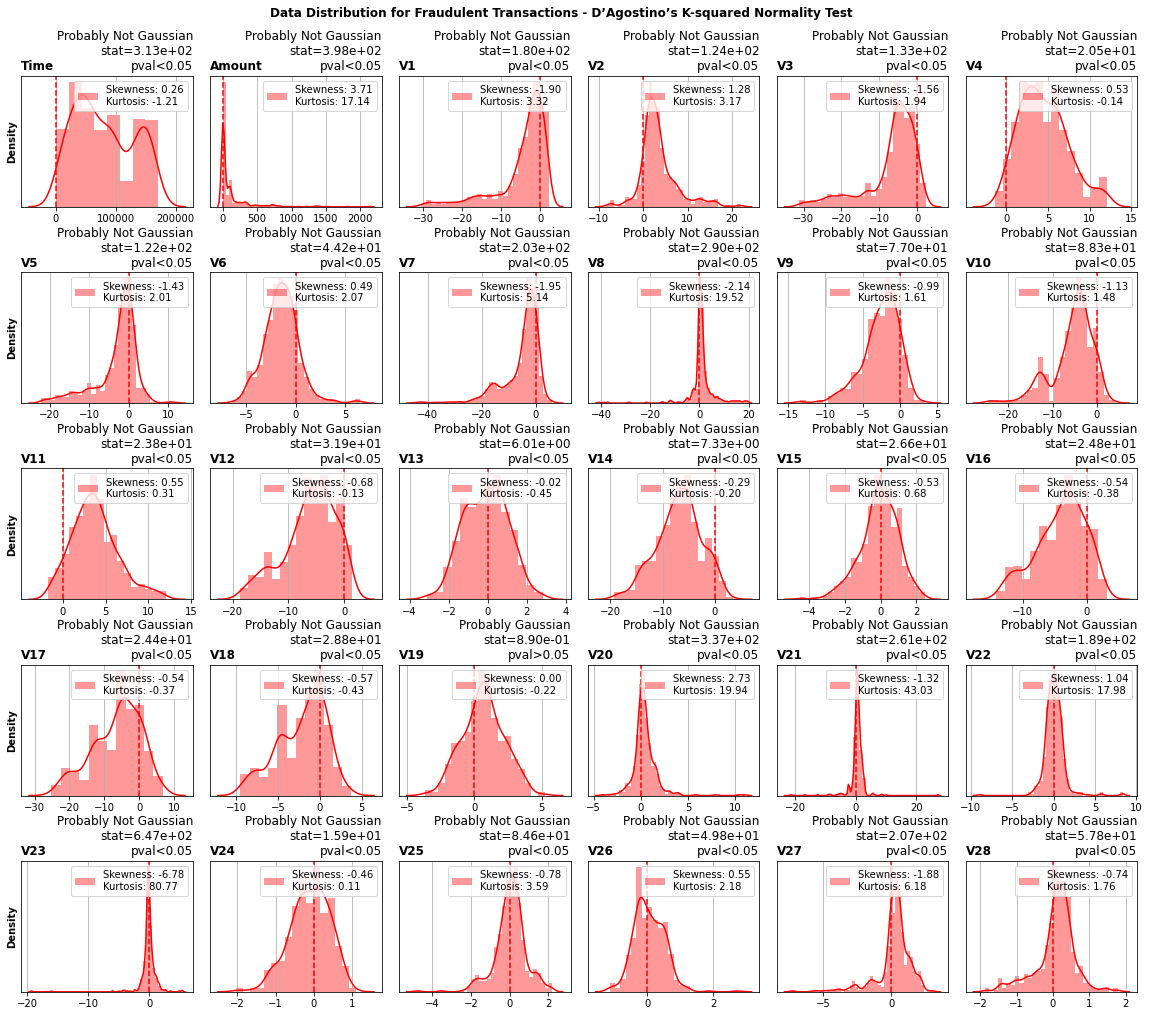

In [14]:
%%time

# Make figure and axes.
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 16))
axes = axes.flatten()

# Only fraudulent transactions.
fraudulent = df[target] == 1
df_tmp = df[fraudulent]

# Plot distribution for each feature.
for axis, feature in zip(axes, features):

    data = df_tmp[feature]
    
    # Skweness and kurtosis for this feature.
    skew = scipy.stats.skew(data)
    kurtosis = scipy.stats.kurtosis(data, fisher=True)
    label = "Skewness: %.2f\nKurtosis: %.2f" %(skew, kurtosis)
    
    plotdata = sns.distplot(
        a=data,
        ax=axis,
        norm_hist=True,
        label=label,
        color="red"
    )
    axis.axvline(ls="--", color="red")   
    
    # Do data have a Gaussian distribution? D’Agostino’s K-squared test.
    statistic, pvalue = scipy.stats.normaltest(data)
    
    if pvalue > 0.05:
        text = "Probably Gaussian\nstat=%.2e\npval>0.05" %(statistic)
    
    else:
        text = "Probably Not Gaussian\nstat=%.2e\npval<0.05" %(statistic)
    
    # Adjustments.   
    axis.legend(loc="upper right")
    axis.set_yticks([])
    axis.set_title(feature, loc="left", weight="bold")
    axis.set_title(text, loc="right")
    plotdata.set_xlabel(None)
    plotdata.grid()
    
# More adjustments.
axes[0].set_ylabel("Density", weight="bold")
axes[6].set_ylabel("Density", weight="bold")
axes[12].set_ylabel("Density", weight="bold")
axes[18].set_ylabel("Density", weight="bold")
axes[24].set_ylabel("Density", weight="bold")
plt.suptitle("Data Distribution for Fraudulent Transactions - D’Agostino’s K-squared Normality Test",
             weight="bold")
plt.subplots_adjust(wspace=0.10, hspace=0.50, top=0.92)

del data

CPU times: user 21.7 s, sys: 16 ms, total: 21.7 s
Wall time: 21.7 s


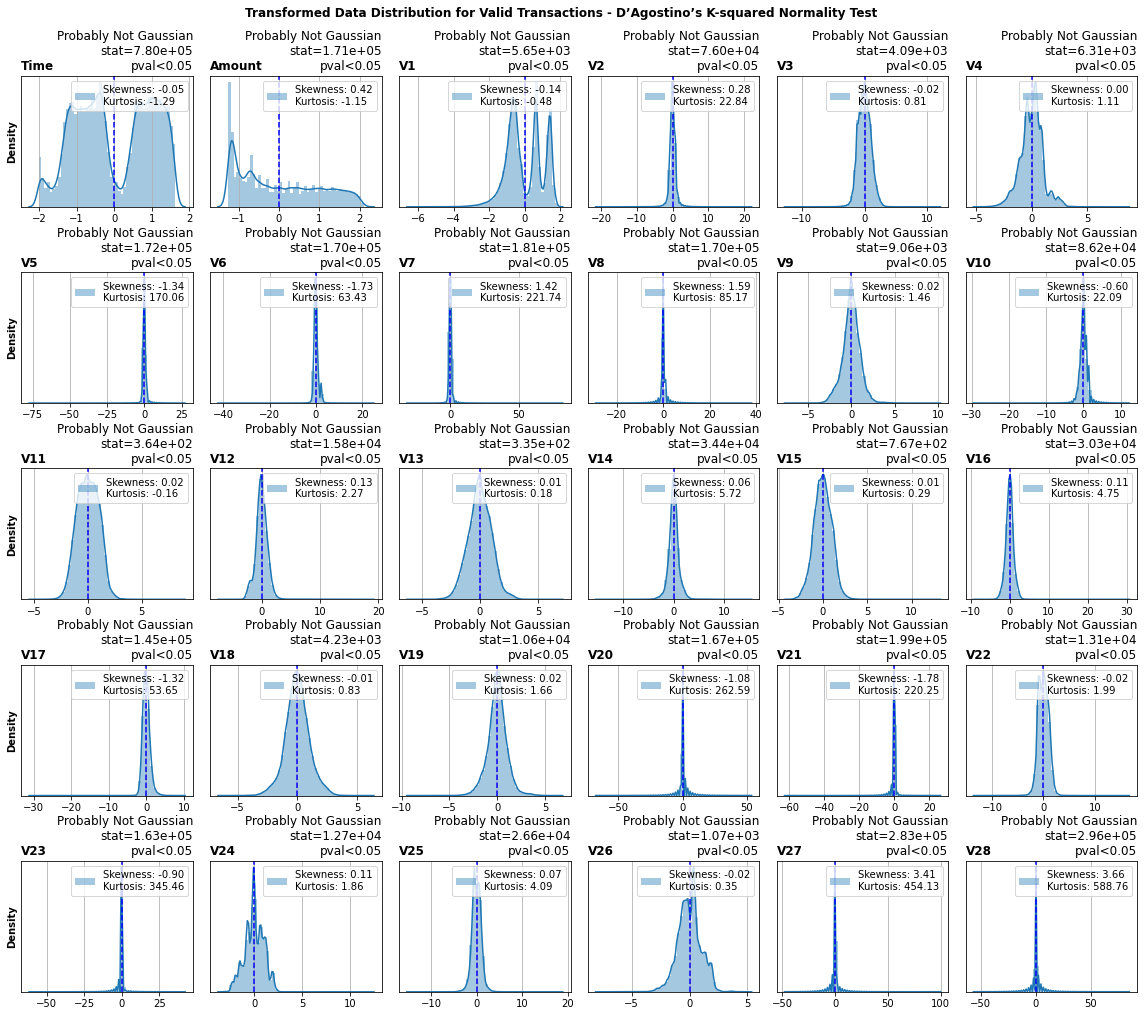

In [15]:
%%time

# Make figure and axes.
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 16))
axes = axes.flatten()

# Only valid transactions.
valid = df[target] == 0
df_tmp = df[valid]

# Plot distribution for each feature.
for axis, feature in zip(axes, features):

    data = df_tmp[feature].values.reshape((-1, 1))
    data = RobustScaler().fit_transform(data)
    data = PowerTransformer(method="yeo-johnson", standardize=True).fit_transform(data)
    
    # Skweness and kurtosis for this feature.
    skew = scipy.stats.skew(data)
    kurtosis = scipy.stats.kurtosis(data, fisher=True)
    label = "Skewness: %.2f\nKurtosis: %.2f" %(skew, kurtosis)
    
    plotdata = sns.distplot(
        a=data,
        ax=axis,
        norm_hist=True,
        label=label
    )
    axis.axvline(ls="--", color="blue")    
    
    # Do data have a Gaussian distribution? D’Agostino’s K-squared test.
    statistic, pvalue = scipy.stats.normaltest(data)
    
    if pvalue > 0.05: # The null hypothesis CANNOT be rejected
        text = "Probably Gaussian\nstat=%.2e\npval>0.05" %(statistic)
    
    else:             # The null hypothesis CAN be rejected.  
        text = "Probably Not Gaussian\nstat=%.2e\npval<0.05" %(statistic)
    
    # Adjustments. 
    axis.legend(loc="upper right")
    axis.set_yticks([])
    axis.set_title(feature, loc="left", weight="bold")
    axis.set_title(text, loc="right")
    plotdata.set_xlabel(None)
    plotdata.grid()
    
# More adjustments.
axes[0].set_ylabel("Density", weight="bold")
axes[6].set_ylabel("Density", weight="bold")
axes[12].set_ylabel("Density", weight="bold")
axes[18].set_ylabel("Density", weight="bold")
axes[24].set_ylabel("Density", weight="bold")
plt.suptitle("Transformed Data Distribution for Valid Transactions - D’Agostino’s K-squared Normality Test",
             weight="bold")
_ = plt.subplots_adjust(wspace=0.10, hspace=0.50, top=0.92)

CPU times: user 1.88 s, sys: 8 ms, total: 1.89 s
Wall time: 1.89 s


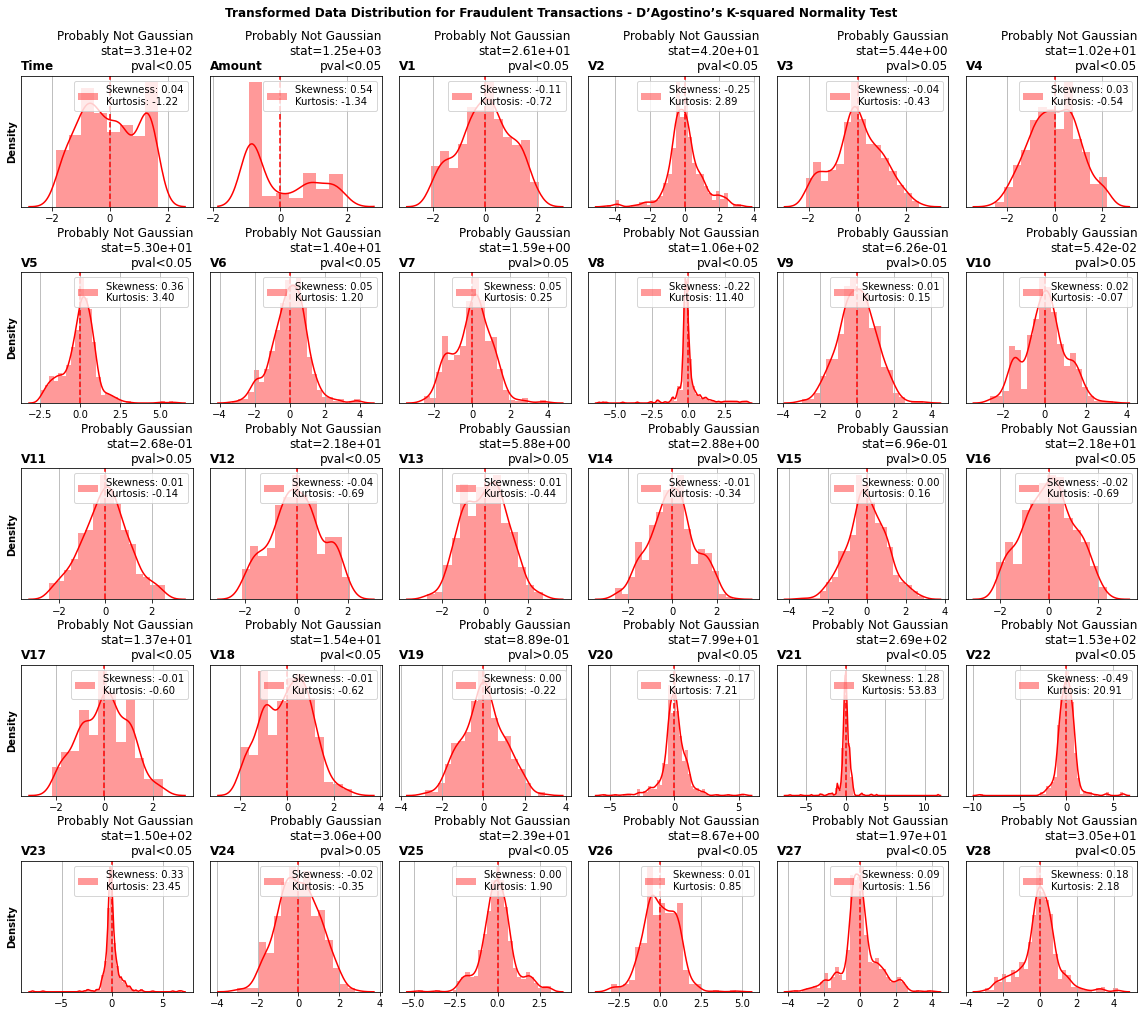

In [16]:
%%time

# Make figure and axes.
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 16))
axes = axes.flatten()

# Only fraudulent transactions.
fraudulent = df[target] == 1
df_tmp = df[fraudulent]

# Plot distribution for each feature.
for axis, feature in zip(axes, features):

    data = df_tmp[feature].values.reshape((-1, 1))
    data = RobustScaler().fit_transform(data)
    data = PowerTransformer(method="yeo-johnson", standardize=True).fit_transform(data)
    
    # Skweness and kurtosis for this feature.
    skew = scipy.stats.skew(data)
    kurtosis = scipy.stats.kurtosis(data, fisher=True)
    label = "Skewness: %.2f\nKurtosis: %.2f" %(skew, kurtosis)
    
    plotdata = sns.distplot(
        a=data,
        ax=axis,
        norm_hist=True,
        label=label,
        color="red"
    )
    axis.axvline(ls="--", color="red")   
    
    # Do data have a Gaussian distribution? D’Agostino’s K-squared test.
    statistic, pvalue = scipy.stats.normaltest(data)
    
    if pvalue > 0.05:
        text = "Probably Gaussian\nstat=%.2e\npval>0.05" %(statistic)
    
    else:
        text = "Probably Not Gaussian\nstat=%.2e\npval<0.05" %(statistic)
    
    # Adjustments.   
    axis.legend(loc="upper right")
    axis.set_yticks([])
    axis.set_title(feature, loc="left", weight="bold")
    axis.set_title(text, loc="right")
    plotdata.set_xlabel(None)
    plotdata.grid()
    
# More adjustments.
axes[0].set_ylabel("Density", weight="bold")
axes[6].set_ylabel("Density", weight="bold")
axes[12].set_ylabel("Density", weight="bold")
axes[18].set_ylabel("Density", weight="bold")
axes[24].set_ylabel("Density", weight="bold")
plt.suptitle("Transformed Data Distribution for Fraudulent Transactions - D’Agostino’s K-squared Normality Test",
             weight="bold")
_ = plt.subplots_adjust(wspace=0.10, hspace=0.50, top=0.92)

In [17]:
%%time

# Create date time index assuming first time step at 00h00min00sec in day 2013-09-01.
datetime = pd.DatetimeIndex([
    pd.Timestamp("2013-09-01") + pd.Timedelta(seconds, unit="sec") for seconds in df["Time"]
])

CPU times: user 9.04 s, sys: 16 ms, total: 9.06 s
Wall time: 9.07 s


CPU times: user 136 ms, sys: 68 ms, total: 204 ms
Wall time: 216 ms


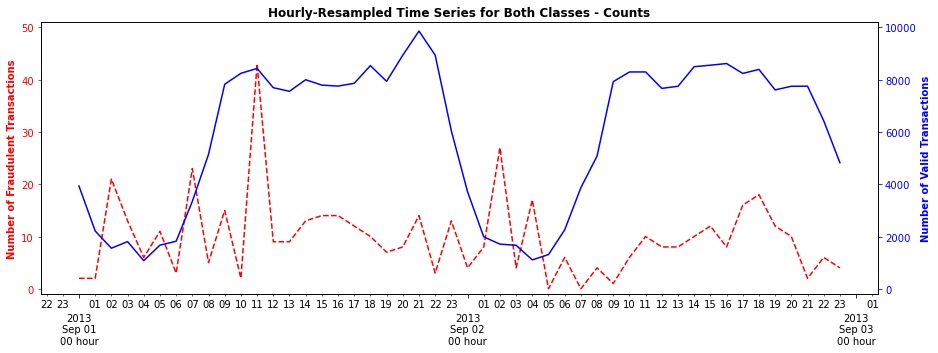

In [18]:
%%time

# Is there a preferential hour when frauds occur?
df_tmp = df.copy()
df_tmp.insert(loc=0, column="DateTime", value=datetime)
plt.figure(figsize=(15, 5))
data = df_tmp[fraudulent].set_index("DateTime")["Class"].resample(rule="1H").count()
plt.plot(data.index, data.values, ls="--", color="red")
axis = plt.gca()

# Are there preferencial hours for valid transactions?
axis2 = axis.twinx()
data = df_tmp[valid].set_index("DateTime")["Class"].resample(rule="1H").count()
axis2.plot(data.index, data.values, color="blue")

# Adjustments.
axis.xaxis.set_major_locator(mdates.DayLocator())
axis.xaxis.set_major_formatter(mdates.DateFormatter("\n%Y\n%b %d\n%H hour"))
axis.xaxis.set_minor_locator(mdates.HourLocator())
axis.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
axis.set_ylim((-1, 51))
axis2.set_ylim((-200, 10200))
axis.set_ylabel("Number of Fraudulent Transactions", weight="bold")
axis.yaxis.label.set_color("red")
axis.tick_params(axis="y", colors="red")
axis2.set_ylabel("Number of Valid Transactions", weight="bold")
axis2.yaxis.label.set_color("blue")
axis2.tick_params(axis="y", colors="blue")
_ = axis.set_title("Hourly-Resampled Time Series for Both Classes - Counts", weight="bold")

CPU times: user 92 ms, sys: 40 ms, total: 132 ms
Wall time: 130 ms


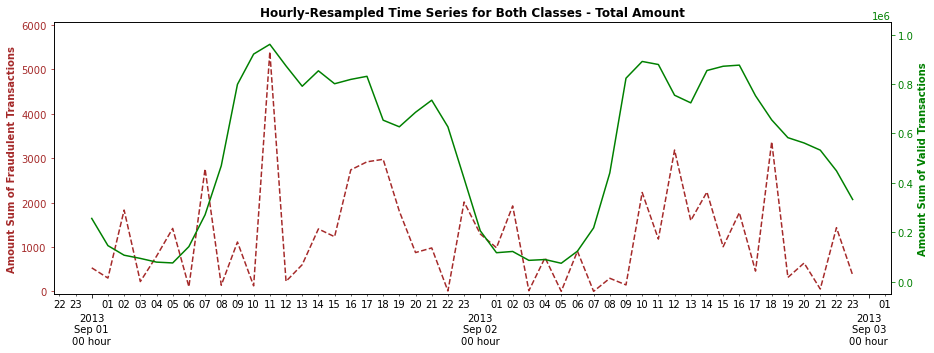

In [19]:
%%time

# Are there amount patterns in fraudulent transactions?
plt.figure(figsize=(15, 5))
data = df_tmp[fraudulent].set_index("DateTime")["Amount"].resample(rule="1H").sum()
plt.plot(data.index, data.values, ls="--", color="brown")
axis = plt.gca()

# Are there amaount patterns for valid transactions?
axis2 = axis.twinx()
data = df_tmp[valid].set_index("DateTime")["Amount"].resample(rule="1H").sum()
axis2.plot(data.index, data.values, color="green")

# Adjustments.
axis.xaxis.set_major_locator(mdates.DayLocator())
axis.xaxis.set_major_formatter(mdates.DateFormatter("\n%Y\n%b %d\n%H hour"))
axis.xaxis.set_minor_locator(mdates.HourLocator())
axis.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
axis.set_ylim((-60, 6060))
axis2.set_ylim((-0.05e6, 1.05e6))
axis.set_ylabel("Amount Sum of Fraudulent Transactions", weight="bold")
axis.yaxis.label.set_color("brown")
axis.tick_params(axis="y", colors="brown")
axis2.set_ylabel("Amount Sum of Valid Transactions", weight="bold")
axis2.yaxis.label.set_color("green")
axis2.tick_params(axis="y", colors="green")
_ = axis.set_title("Hourly-Resampled Time Series for Both Classes - Total Amount", weight="bold")

## Data Split

In [20]:
# Split proportions.
test_size = 0.20
train_size = 1 - test_size

# Total number of instances.
N = df.shape[0]

# Train-test split.
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df.drop(labels=["Time", "Class"], axis="columns"), 
    df["Class"], 
    stratify=df["Class"], 
    test_size=test_size
) 

# Information.
print(">>> Shape and percentual of instances:")
print(f"* Train-Validation:  {df_X_train.shape}; ({df_X_train.shape[0] / N * 100:.2f}%)")
print(f"* Test:              {df_X_test.shape};  ({df_X_test.shape[0] / N * 100:.2f}%)")

# More information.
print("\n>>> Train-Validation target percentages:")
print(df_y_train.value_counts() / df_y_train.size * 100)
print("\n>>> Test target percentages:")
print(df_y_test.value_counts() / df_y_test.size * 100)

>>> Shape and percentual of instances:
* Train-Validation:  (226980, 29); (80.00%)
* Test:              (56746, 29);  (20.00%)

>>> Train-Validation target percentages:
0    99.833466
1     0.166534
Name: Class, dtype: float64

>>> Test target percentages:
0    99.832587
1     0.167413
Name: Class, dtype: float64


- **Data Split:**
    - Stratified random train-validation (**80%**) and test (**20%**) subsets.

## Dummy Classifier (Most Frequent Class)

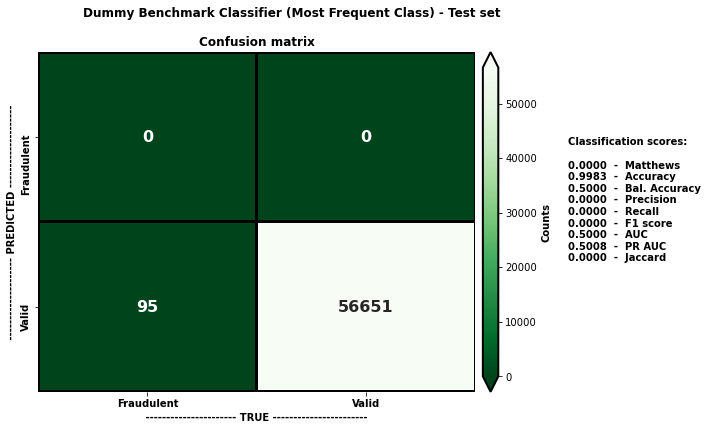

In [21]:
# Used in dictionary with results.
model_code = "dummy"

# Just a benchmark.
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(df_X_train, df_y_train)

# Keep results.
models[model_code] = dummy_classifier
results[model_code] = all_scores(
    model=dummy_classifier, 
    X_true=df_X_test, 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=dummy_classifier, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Dummy Benchmark Classifier (Most Frequent Class) - Test set"
)

## K-Nearest Neighbors Classifier

In [22]:
%%time

# Used in dictionary with results.
model_code = "knncla"

# Input features for this model.
used_features = df_X_train.columns

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("yeo_johnson", PowerTransformer(method="yeo-johnson", standardize=True)),
        ("pca", PCA()),
        ("rescaler", MinMaxScaler(feature_range=(0, 1))),
        ("model", KNeighborsClassifier())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={
        "pca__n_components": [2, 3, 5],
        "model__n_neighbors": [1, 3, 5],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2, 3]
    },
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train[used_features], df_y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  5.5min finished


CPU times: user 26.6 s, sys: 2.5 s, total: 29.1 s
Wall time: 5min 41s


In [23]:
# Number of tested models.
n_candidates = len(search.cv_results_["params"])

# Number of used features.
n_features = search.n_features_in_

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df_tmp = pd.DataFrame(search.cv_results_)
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                                         18.3356
std_fit_time                                                         0.264051
mean_score_time                                                       14.0327
std_score_time                                                       0.416439
param_model__n_neighbors                                                    3
param_model__p                                                              3
param_model__weights                                                 distance
param_pca__n_components                                                     5
params                      {'model__n_neighbors': 3, 'model__p': 3, 'mode...
split0_test_score                                                    0.621835
split1_test_score                                                    0.505209
split2_test_score                                                    0.630519
split3_test_score       

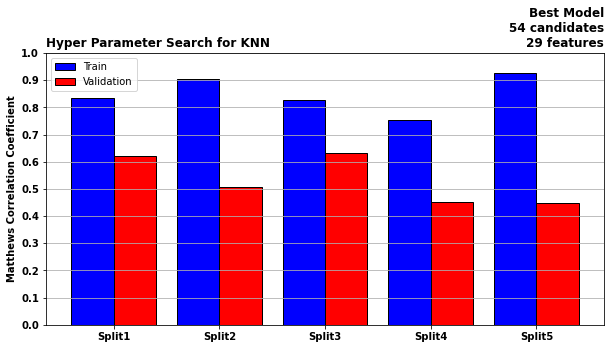

In [24]:
# Train and validation scores for optimum hyper parameter set.
train_cols = [col for col in df_tmp.columns if ("split" in col) and ("train" in col)]
validation_cols = [col for col in df_tmp.columns if ("split" in col) and ("test" in col)]
x = np.arange(1, search.cv.n_splits + 1)
df_tmp = pd.DataFrame(
    data=np.column_stack((
        x,
        df_tmp.iloc[search.best_index_].loc[train_cols], 
        df_tmp.iloc[search.best_index_].loc[validation_cols]
    )),
    columns=["Split", "Train", "Validation"]
)

# Make figure.
plt.figure(figsize=(10, 5))
plt.bar(x - 0.40, df_tmp.Train, width=0.40, color="blue", label="Train", align="edge",
        edgecolor="black")
plt.bar(x, df_tmp.Validation, width=0.40, color="red", label="Validation", align="edge",
        edgecolor="black")
plt.legend()
plt.ylim((0, 1))
plt.yticks(np.arange(0, 1.1, 0.1), weight="bold")
plt.grid(axis="y")
plt.gca().set_xticklabels([""] + ["Split" + str(num) for num in x], weight="bold")
plt.ylabel("Matthews Correlation Coefficient", weight="bold")
plt.title("Hyper Parameter Search for KNN", weight="bold", loc="left")
_ = plt.title(f"Best Model\n{n_candidates} candidates\n{n_features} features", 
              weight="bold", loc="right")

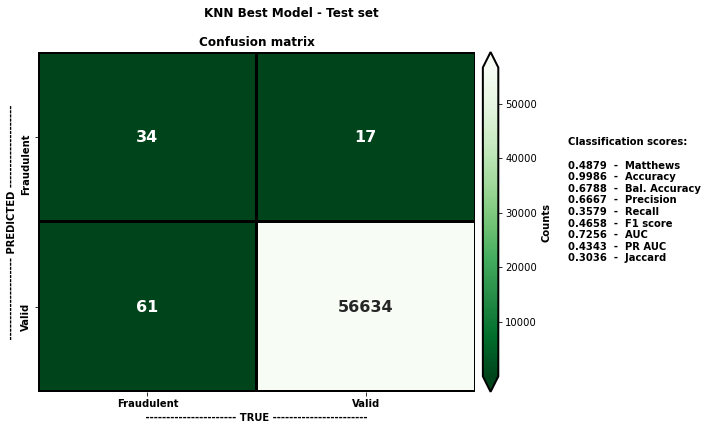

In [25]:
# Keep results.
models[model_code] = search.best_estimator_
results[model_code] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="KNN Best Model - Test set"
)

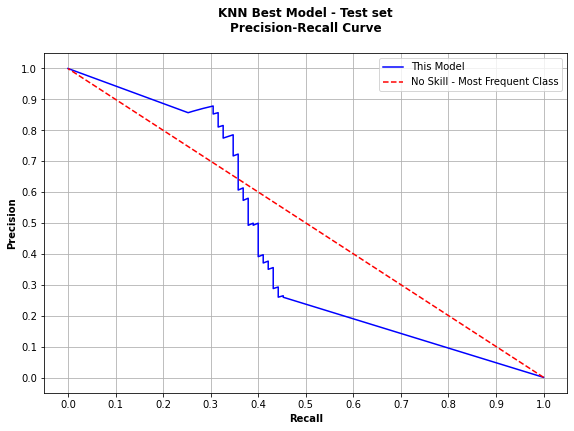

In [26]:
# Show results for test set.
plot_pr_roc(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="KNN Best Model - Test set"
)

CPU times: user 14.8 s, sys: 348 ms, total: 15.2 s
Wall time: 10min 49s


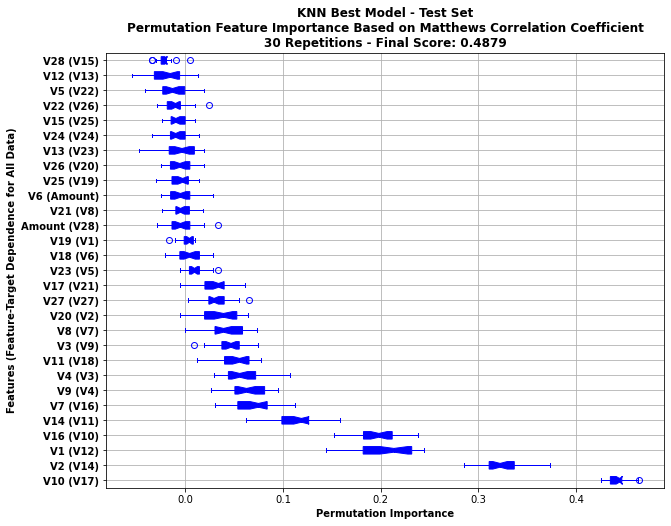

In [27]:
%%time

# Importance of features in test set.
n_repeats = 30
PI = permutation_importance(
    estimator=search.best_estimator_,
    X=df_X_test,
    y=df_y_test,
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_repeats=n_repeats,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
PI = PI.importances[order, :]
used_features_ordered = np.array(used_features)[order]

# Make figure.
plt.figure(figsize=(10, 8))
plt.boxplot(
    notch=True,
    x=PI.T,
    vert=False,
    labels=used_features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)

# Adjustments.
ax = plt.gca()
ax.set_xlabel("Permutation Importance", weight="bold")
ax.set_ylabel("Features (Feature-Target Dependence for All Data)", weight="bold")
ax.set_title("KNN Best Model - Test Set\n" + \
             "Permutation Feature Importance Based on Matthews Correlation Coefficient\n" + \
             f"{n_repeats} Repetitions - Final Score: {results[model_code][0]:.4f}", 
             weight="bold")
ax.grid()
p1 = used_features_ordered
p2 = mi_ordered.index.drop("Time")[::-1]
yticklabels = [v1 + " (" + v2 + ")" for v1, v2 in zip(p1, p2)]
_ = ax.set_yticklabels(yticklabels, weight="bold")

## Logistic Regression

In [28]:
%%time

# Used in dictionary with results.
model_code = "logreg"

# Input features for this model.
used_features = df_X_train.columns

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("scaler", RobustScaler()),
        ("yeo_johnson", PowerTransformer(method="yeo-johnson", standardize=True)),
        ("model", LogisticRegression())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={"model__C": np.power(10, np.linspace(start=-6, stop=6, num=100))},
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train[used_features], df_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.4min finished


CPU times: user 35.7 s, sys: 2.51 s, total: 38.2 s
Wall time: 4min 39s


In [29]:
# Number of tested models.
n_candidates = len(search.cv_results_["params"])

# Number of used features.
n_features = search.n_features_in_

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df_tmp = pd.DataFrame(search.cv_results_)
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                 19.2851
std_fit_time                                 0.422204
mean_score_time                              0.324625
std_score_time                             0.00552292
param_model__C                              0.0932603
params                {'model__C': 0.093260334688322}
split0_test_score                            0.734509
split1_test_score                            0.722632
split2_test_score                            0.725194
split3_test_score                            0.740202
split4_test_score                            0.804981
mean_test_score                              0.745504
std_test_score                              0.0304044
rank_test_score                                     1
split0_train_score                           0.763955
split1_train_score                           0.740621
split2_train_score                            0.79652
split3_train_score                        

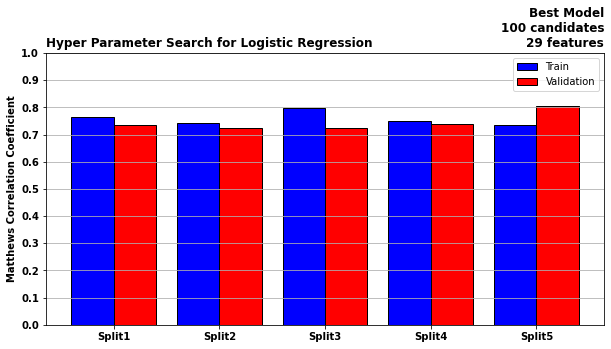

In [30]:
# Train and validation scores for optimum hyper parameter set.
train_cols = [col for col in df_tmp.columns if ("split" in col) and ("train" in col)]
validation_cols = [col for col in df_tmp.columns if ("split" in col) and ("test" in col)]
x = np.arange(1, search.cv.n_splits + 1)
df_tmp = pd.DataFrame(
    data=np.column_stack((
        x,
        df_tmp.iloc[search.best_index_].loc[train_cols], 
        df_tmp.iloc[search.best_index_].loc[validation_cols]
    )),
    columns=["Split", "Train", "Validation"]
)

# Make figure.
plt.figure(figsize=(10, 5))
plt.bar(x - 0.40, df_tmp.Train, width=0.40, color="blue", label="Train", align="edge",
        edgecolor="black")
plt.bar(x, df_tmp.Validation, width=0.40, color="red", label="Validation", align="edge",
        edgecolor="black")
plt.legend()
plt.ylim((0, 1))
plt.yticks(np.arange(0, 1.1, 0.1), weight="bold")
plt.grid(axis="y")
plt.gca().set_xticklabels([""] + ["Split" + str(num) for num in x], weight="bold")
plt.ylabel("Matthews Correlation Coefficient", weight="bold")
plt.title("Hyper Parameter Search for Logistic Regression", weight="bold", loc="left")
_ = plt.title(f"Best Model\n{n_candidates} candidates\n{n_features} features", 
          weight="bold", loc="right")

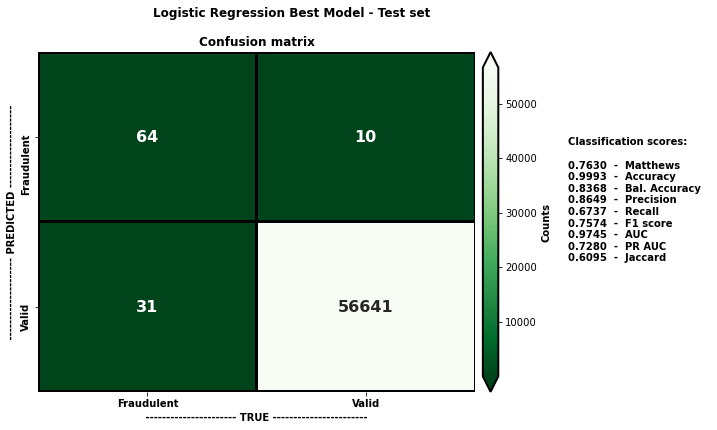

In [31]:
# Keep results.
models[model_code] = search.best_estimator_
results[model_code] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Logistic Regression Best Model - Test set"
)

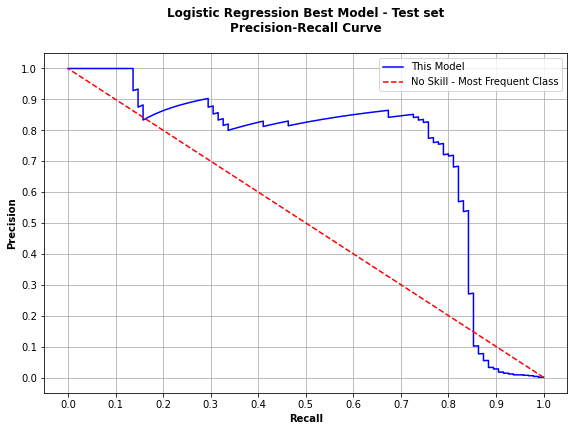

In [32]:
# Show results for test set.
plot_pr_roc(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Logistic Regression Best Model - Test set"
)

CPU times: user 4.13 s, sys: 280 ms, total: 4.41 s
Wall time: 12.1 s


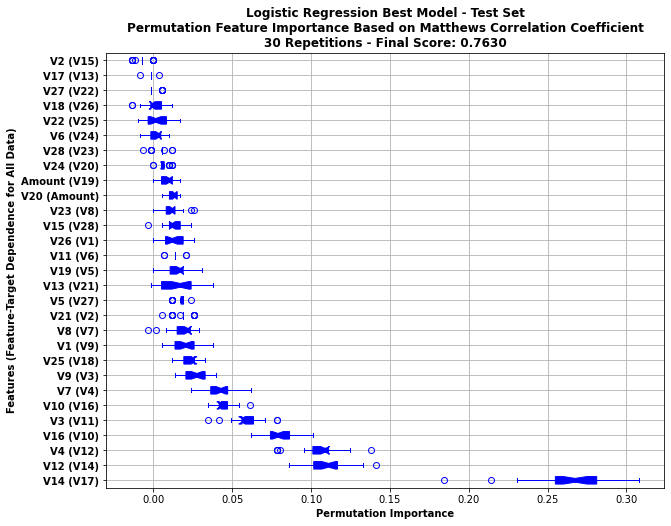

In [33]:
%%time

# Importance of features in test set.
n_repeats = 30
PI = permutation_importance(
    estimator=search.best_estimator_,
    X=df_X_test,
    y=df_y_test,
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_repeats=n_repeats,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
PI = PI.importances[order, :]
used_features_ordered = np.array(used_features)[order]

# Make figure.
plt.figure(figsize=(10, 8))
plt.boxplot(
    notch=True,
    x=PI.T,
    vert=False,
    labels=used_features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)

# Adjustments.
ax = plt.gca()
ax.set_xlabel("Permutation Importance", weight="bold")
ax.set_ylabel("Features (Feature-Target Dependence for All Data)", weight="bold")
ax.set_title("Logistic Regression Best Model - Test Set\n" + \
             "Permutation Feature Importance Based on Matthews Correlation Coefficient\n" + \
             f"{n_repeats} Repetitions - Final Score: {results[model_code][0]:.4f}", 
             weight="bold")
ax.grid()
p1 = used_features_ordered
p2 = mi_ordered.index.drop("Time")[::-1]
yticklabels = [v1 + " (" + v2 + ")" for v1, v2 in zip(p1, p2)]
_ = ax.set_yticklabels(yticklabels, weight="bold")

## Multi-Layer Perceptron

In [34]:
%%time

# Used in dictionary with results.
model_code = "mlpcla"

# Input features for this model.
used_features = df_X_train.columns

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("scaler", RobustScaler()),
        ("yeo_johnson", PowerTransformer(method="yeo-johnson", standardize=True)),
        ("model", MLPClassifier())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={
        "model__hidden_layer_sizes": [(100,), (10, 10), (5, 5, 5)],
        "model__activation": ["identity", "tanh", "relu"],
        "model__alpha": [0.0001, 0.001, 0.01],
        "model__batch_size": [100, 200, 400],
        "model__learning_rate": ["constant", "adaptive"]
    },
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train[used_features], df_y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 20.2min finished


CPU times: user 11min 17s, sys: 22.6 s, total: 11min 40s
Wall time: 21min 1s


In [35]:
# Number of tested models.
n_candidates = len(search.cv_results_["params"])

# Number of used features.
n_features = search.n_features_in_

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df_tmp = pd.DataFrame(search.cv_results_)
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                                                54.1569
std_fit_time                                                                 1.59667
mean_score_time                                                              0.59018
std_score_time                                                            0.00609574
param_model__activation                                                         tanh
param_model__alpha                                                              0.01
param_model__batch_size                                                          400
param_model__hidden_layer_sizes                                               (100,)
param_model__learning_rate                                                  adaptive
params                             {'model__activation': 'tanh', 'model__alpha': ...
split0_test_score                                                            0.84478
split1_test_score        

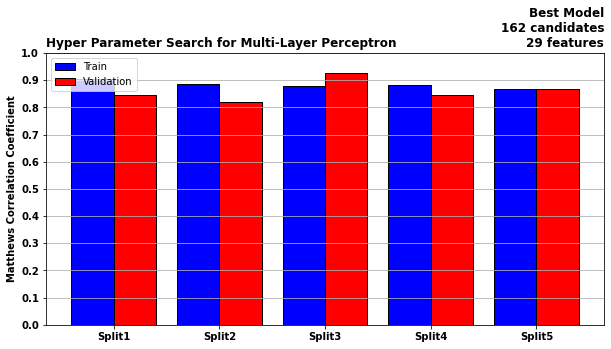

In [36]:
# Train and validation scores for optimum hyper parameter set.
train_cols = [col for col in df_tmp.columns if ("split" in col) and ("train" in col)]
validation_cols = [col for col in df_tmp.columns if ("split" in col) and ("test" in col)]
x = np.arange(1, search.cv.n_splits + 1)
df_tmp = pd.DataFrame(
    data=np.column_stack((
        x,
        df_tmp.iloc[search.best_index_].loc[train_cols], 
        df_tmp.iloc[search.best_index_].loc[validation_cols]
    )),
    columns=["Split", "Train", "Validation"]
)

# Make figure.
plt.figure(figsize=(10, 5))
plt.bar(x - 0.40, df_tmp.Train, width=0.40, color="blue", label="Train", align="edge",
        edgecolor="black")
plt.bar(x, df_tmp.Validation, width=0.40, color="red", label="Validation", align="edge",
        edgecolor="black")
plt.legend()
plt.ylim((0, 1))
plt.yticks(np.arange(0, 1.1, 0.1), weight="bold")
plt.grid(axis="y")
plt.gca().set_xticklabels([""] + ["Split" + str(num) for num in x], weight="bold")
plt.ylabel("Matthews Correlation Coefficient", weight="bold")
plt.title("Hyper Parameter Search for Multi-Layer Perceptron", weight="bold", loc="left")
_ = plt.title(f"Best Model\n{n_candidates} candidates\n{n_features} features", 
          weight="bold", loc="right")

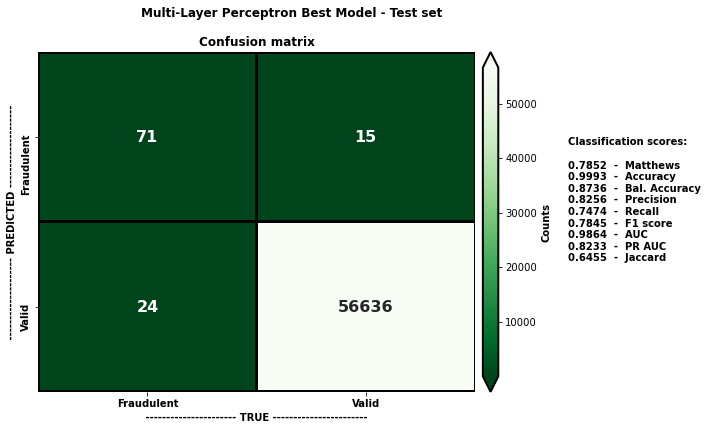

In [37]:
# Keep results.
models[model_code] = search.best_estimator_
results[model_code] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Multi-Layer Perceptron Best Model - Test set"
)

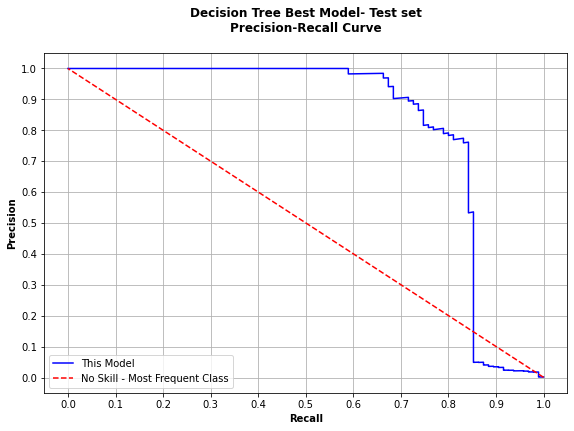

In [38]:
# Show results for test set.
plot_pr_roc(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Decision Tree Best Model- Test set"
)

CPU times: user 7.62 s, sys: 400 ms, total: 8.02 s
Wall time: 21.4 s


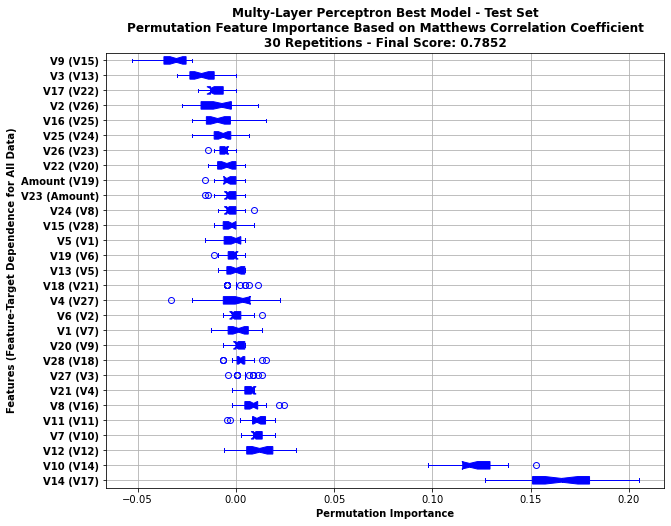

In [39]:
%%time

# Importance of features in test set.
n_repeats = 30
PI = permutation_importance(
    estimator=search.best_estimator_,
    X=df_X_test,
    y=df_y_test,
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_repeats=n_repeats,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
PI = PI.importances[order, :]
used_features_ordered = np.array(used_features)[order]

# Make figure.
plt.figure(figsize=(10, 8))
plt.boxplot(
    notch=True,
    x=PI.T,
    vert=False,
    labels=used_features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)

# Adjustments.
ax = plt.gca()
ax.set_xlabel("Permutation Importance", weight="bold")
ax.set_ylabel("Features (Feature-Target Dependence for All Data)", weight="bold")
ax.set_title("Multy-Layer Perceptron Best Model - Test Set\n" + \
             "Permutation Feature Importance Based on Matthews Correlation Coefficient\n" + \
             f"{n_repeats} Repetitions - Final Score: {results[model_code][0]:.4f}", 
             weight="bold")
ax.grid()
p1 = used_features_ordered
p2 = mi_ordered.index.drop("Time")[::-1]
yticklabels = [v1 + " (" + v2 + ")" for v1, v2 in zip(p1, p2)]
_ = ax.set_yticklabels(yticklabels, weight="bold")

## Decision Tree

In [40]:
%%time

# Used in dictionary with results.
model_code = "dectre"

# Input features for this model.
used_features = df_X_train.columns

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("pca", PCA()),
        ("model", DecisionTreeClassifier())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={
        "model__criterion": ["gini", "entropy"],
        "model__splitter": ["best", "random"],
        "model__max_depth": [3, 4, 5, 6, 7, 10, 50],
        "model__max_features": [int(3), int(15), int(20), int(29)]
    },
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train[used_features], df_y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  1.4min finished


CPU times: user 16.5 s, sys: 2.38 s, total: 18.9 s
Wall time: 1min 29s


In [41]:
# Number of tested models.
n_candidates = len(search.cv_results_["params"])

# Number of used features.
n_features = search.n_features_in_

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df_tmp = pd.DataFrame(search.cv_results_)
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                                          8.03529
std_fit_time                                                          0.810007
mean_score_time                                                       0.107633
std_score_time                                                       0.0125038
param_model__criterion                                                    gini
param_model__max_depth                                                       6
param_model__max_features                                                   20
param_model__splitter                                                     best
params                       {'model__criterion': 'gini', 'model__max_depth...
split0_test_score                                                     0.816091
split1_test_score                                                     0.808001
split2_test_score                                                     0.794543
split3_test_

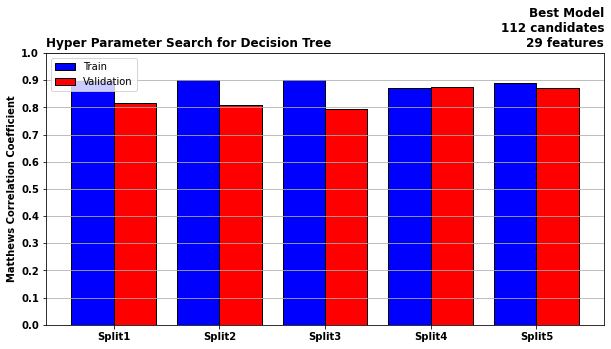

In [42]:
# Train and validation scores for optimum hyper parameter set.
train_cols = [col for col in df_tmp.columns if ("split" in col) and ("train" in col)]
validation_cols = [col for col in df_tmp.columns if ("split" in col) and ("test" in col)]
x = np.arange(1, search.cv.n_splits + 1)
df_tmp = pd.DataFrame(
    data=np.column_stack((
        x,
        df_tmp.iloc[search.best_index_].loc[train_cols], 
        df_tmp.iloc[search.best_index_].loc[validation_cols]
    )),
    columns=["Split", "Train", "Validation"]
)

# Make figure.
plt.figure(figsize=(10, 5))
plt.bar(x - 0.40, df_tmp.Train, width=0.40, color="blue", label="Train", align="edge",
        edgecolor="black")
plt.bar(x, df_tmp.Validation, width=0.40, color="red", label="Validation", align="edge",
        edgecolor="black")
plt.legend()
plt.ylim((0, 1))
plt.yticks(np.arange(0, 1.1, 0.1), weight="bold")
plt.grid(axis="y")
plt.gca().set_xticklabels([""] + ["Split" + str(num) for num in x], weight="bold")
plt.ylabel("Matthews Correlation Coefficient", weight="bold")
plt.title("Hyper Parameter Search for Decision Tree", weight="bold", loc="left")
_ = plt.title(f"Best Model\n{n_candidates} candidates\n{n_features} features", 
          weight="bold", loc="right")

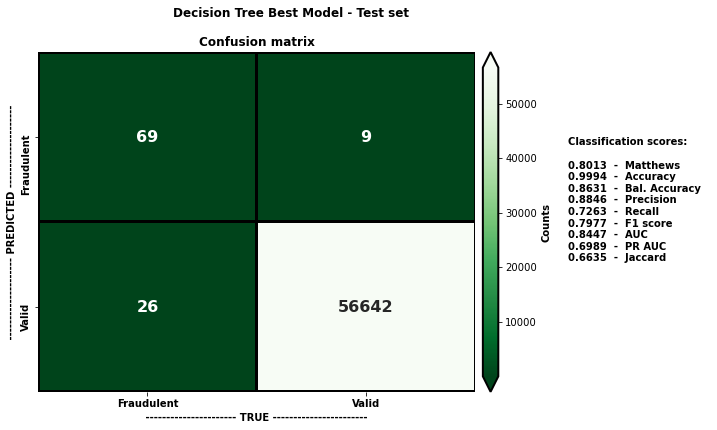

In [43]:
# Keep results.
models[model_code] = search.best_estimator_
results[model_code] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Decision Tree Best Model - Test set"
)

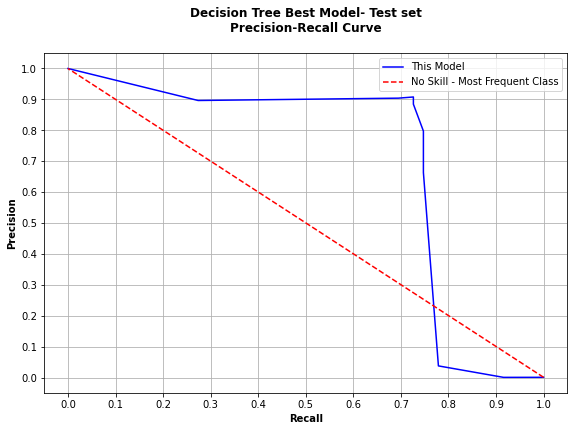

In [44]:
# Show results for test set.
plot_pr_roc(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Decision Tree Best Model- Test set"
)

CPU times: user 3.84 s, sys: 264 ms, total: 4.1 s
Wall time: 4.52 s


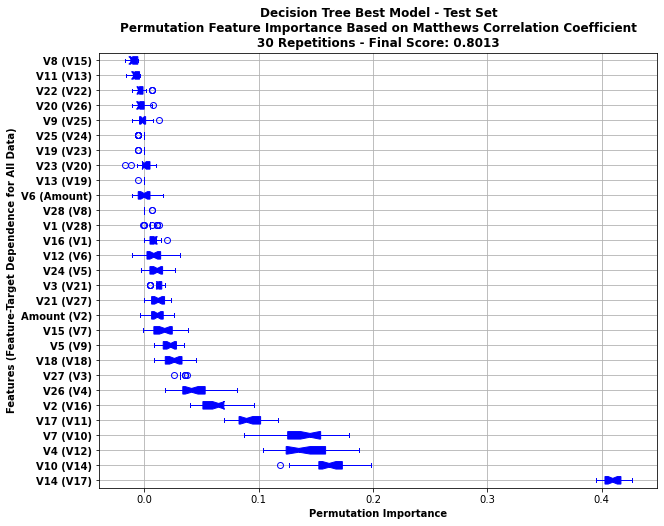

In [45]:
%%time

# Importance of features in test set.
n_repeats = 30
PI = permutation_importance(
    estimator=search.best_estimator_,
    X=df_X_test,
    y=df_y_test,
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_repeats=n_repeats,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
PI = PI.importances[order, :]
used_features_ordered = np.array(used_features)[order]

# Make figure.
plt.figure(figsize=(10, 8))
plt.boxplot(
    notch=True,
    x=PI.T,
    vert=False,
    labels=used_features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)

# Adjustments.
ax = plt.gca()
ax.set_xlabel("Permutation Importance", weight="bold")
ax.set_ylabel("Features (Feature-Target Dependence for All Data)", weight="bold")
ax.set_title("Decision Tree Best Model - Test Set\n" + \
             "Permutation Feature Importance Based on Matthews Correlation Coefficient\n" + \
             f"{n_repeats} Repetitions - Final Score: {results[model_code][0]:.4f}", 
             weight="bold")
ax.grid()
p1 = used_features_ordered
p2 = mi_ordered.index.drop("Time")[::-1]
yticklabels = [v1 + " (" + v2 + ")" for v1, v2 in zip(p1, p2)]
_ = ax.set_yticklabels(yticklabels, weight="bold")

## XGBoost Classifier

In [46]:
%%time

# Used in dictionary with results.
model_code = "xgboos"

# Best decision tree previously found.
# {'model__criterion': 'entropy', 
#  'model__max_depth': 5, 
#  'model__max_features': 29, 
#  'model__splitter': 'best'}

# Input features for this model.
used_features = ["V26", "V27", "V21", "V8", "V7", "V16", "V17", "V10", "V14"]

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("model", XGBClassifier())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={
        "model__n_estimators": [100, 200],
        "model__max_depth":[5],
        "model__scale_pos_weight": [100, 600],
        "model__learning_rate": [0.075, 0.10],
        "model__reg_alpha": [0.1, 1],
        "model__reg_lambda": [0.1, 1]
    },
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train[used_features], df_y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  6.4min finished


CPU times: user 8min 33s, sys: 13.7 s, total: 8min 46s
Wall time: 6min 39s


In [47]:
# Number of tested models.
n_candidates = len(search.cv_results_["params"])

# Number of used features.
n_features = search.n_features_in_

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df_tmp = pd.DataFrame(search.cv_results_)
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                                              114.224
std_fit_time                                                               0.57429
mean_score_time                                                           0.585351
std_score_time                                                           0.0147251
param_model__learning_rate                                                     0.1
param_model__max_depth                                                           5
param_model__n_estimators                                                      200
param_model__reg_alpha                                                         0.1
param_model__reg_lambda                                                        0.1
param_model__scale_pos_weight                                                  100
params                           {'model__learning_rate': 0.1, 'model__max_dept...
split0_test_score                              

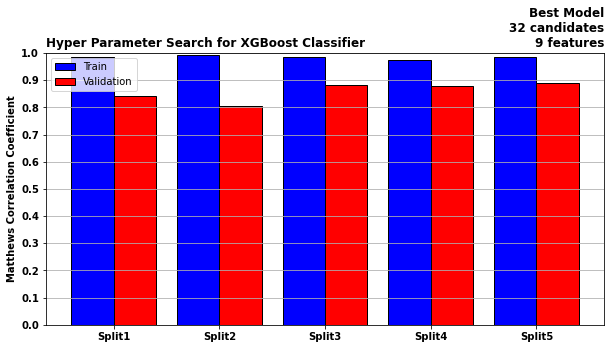

In [48]:
# Train and validation scores for optimum hyper parameter set.
train_cols = [col for col in df_tmp.columns if ("split" in col) and ("train" in col)]
validation_cols = [col for col in df_tmp.columns if ("split" in col) and ("test" in col)]
x = np.arange(1, search.cv.n_splits + 1)
df_tmp = pd.DataFrame(
    data=np.column_stack((
        x,
        df_tmp.iloc[search.best_index_].loc[train_cols], 
        df_tmp.iloc[search.best_index_].loc[validation_cols]
    )),
    columns=["Split", "Train", "Validation"]
)

# Make figure.
plt.figure(figsize=(10, 5))
plt.bar(x - 0.40, df_tmp.Train, width=0.40, color="blue", label="Train", align="edge",
        edgecolor="black")
plt.bar(x, df_tmp.Validation, width=0.40, color="red", label="Validation", align="edge",
        edgecolor="black")
plt.legend()
plt.ylim((0, 1))
plt.yticks(np.arange(0, 1.1, 0.1), weight="bold")
plt.grid(axis="y")
plt.gca().set_xticklabels([""] + ["Split" + str(num) for num in x], weight="bold")
plt.ylabel("Matthews Correlation Coefficient", weight="bold")
plt.title("Hyper Parameter Search for XGBoost Classifier", weight="bold", loc="left")
_ = plt.title(f"Best Model\n{n_candidates} candidates\n{n_features} features", 
          weight="bold", loc="right") 

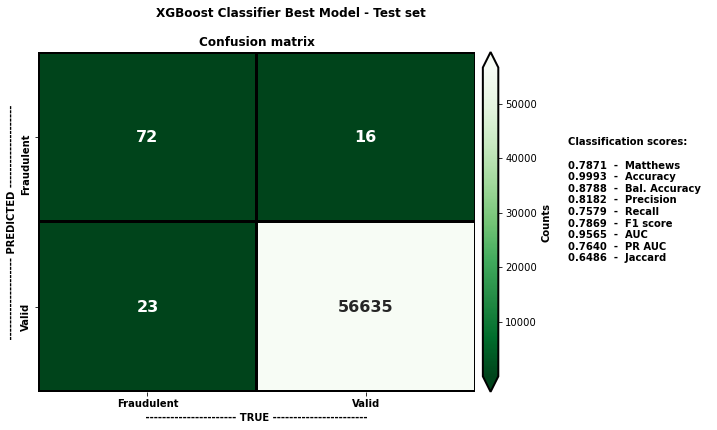

In [49]:
# Keep results.
models[model_code] = search.best_estimator_
results[model_code] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test,
    model_name="XGBoost Classifier Best Model - Test set"
)

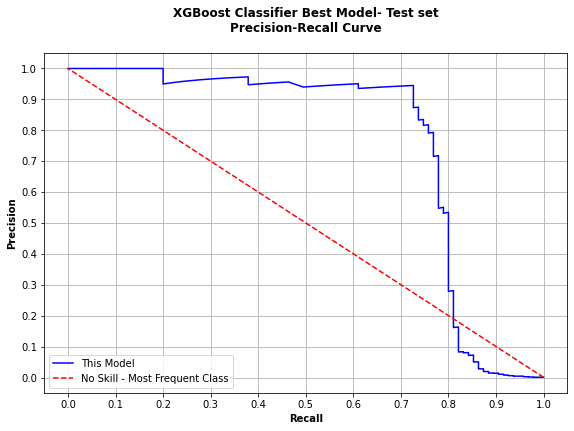

In [50]:
# Show results for test set.
plot_pr_roc(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test,
    model_name="XGBoost Classifier Best Model- Test set"
)

CPU times: user 7.72 s, sys: 356 ms, total: 8.08 s
Wall time: 16.3 s


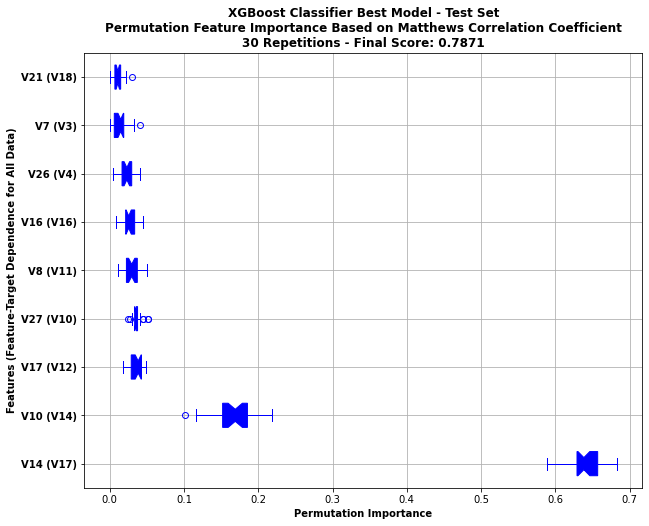

In [51]:
%%time

# Importance of features in test set.
n_repeats = 30
PI = permutation_importance(
    estimator=search.best_estimator_,
    X=df_X_test[used_features],
    y=df_y_test,
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_repeats=n_repeats,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
PI = PI.importances[order, :]
used_features_ordered = np.array(used_features)[order]

# Make figure.
plt.figure(figsize=(10, 8))
plt.boxplot(
    notch=True,
    x=PI.T,
    vert=False,
    labels=used_features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)

# Adjustments.
ax = plt.gca()
ax.set_xlabel("Permutation Importance", weight="bold")
ax.set_ylabel("Features (Feature-Target Dependence for All Data)", weight="bold")
ax.set_title("XGBoost Classifier Best Model - Test Set\n" + \
             "Permutation Feature Importance Based on Matthews Correlation Coefficient\n" + \
             f"{n_repeats} Repetitions - Final Score: {results[model_code][0]:.4f}", 
             weight="bold")
ax.grid()
p1 = used_features_ordered
p2 = mi_ordered.index.drop("Time")[::-1]
yticklabels = [v1 + " (" + v2 + ")" for v1, v2 in zip(p1, p2)]
_ = ax.set_yticklabels(yticklabels, weight="bold")

## Random Forest

In [52]:
%%time

# Used in dictionary with results.
model_code = "ranfor"

# Best decision tree previously found.
# {'model__criterion': 'entropy', 
#  'model__max_depth': 5, 
#  'model__max_features': 29, 
#  'model__splitter': 'best'}

# Input features for this model.
used_features = ["V26", "V27", "V21", "V8", "V7", "V16", "V17", "V10", "V14"]

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("model", XGBRFClassifier())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={
        "model__n_estimators": [100, 200],
        "model__max_depth":[5],
        "model__scale_pos_weight": [100, 600],
        "model__learning_rate": [0.075, 0.10],
        "model__reg_alpha": [0.1, 1],
        "model__reg_lambda": [0.1, 1]
    },
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train[used_features], df_y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  4.5min finished


CPU times: user 4min 20s, sys: 8 s, total: 4min 28s
Wall time: 4min 36s


In [53]:
# Number of tested models.
n_candidates = len(search.cv_results_["params"])

# Number of used features.
n_features = search.n_features_in_

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df_tmp = pd.DataFrame(search.cv_results_)
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                                              44.1071
std_fit_time                                                               2.46922
mean_score_time                                                           0.284336
std_score_time                                                           0.0150279
param_model__learning_rate                                                   0.075
param_model__max_depth                                                           5
param_model__n_estimators                                                      100
param_model__reg_alpha                                                         0.1
param_model__reg_lambda                                                        0.1
param_model__scale_pos_weight                                                  100
params                           {'model__learning_rate': 0.075, 'model__max_de...
split0_test_score                              

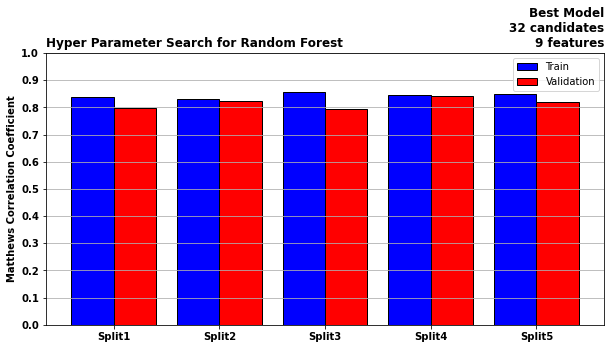

In [54]:
# Train and validation scores for optimum hyper parameter set.
train_cols = [col for col in df_tmp.columns if ("split" in col) and ("train" in col)]
validation_cols = [col for col in df_tmp.columns if ("split" in col) and ("test" in col)]
x = np.arange(1, search.cv.n_splits + 1)
df_tmp = pd.DataFrame(
    data=np.column_stack((
        x,
        df_tmp.iloc[search.best_index_].loc[train_cols], 
        df_tmp.iloc[search.best_index_].loc[validation_cols]
    )),
    columns=["Split", "Train", "Validation"]
)

# Make figure.
plt.figure(figsize=(10, 5))
plt.bar(x - 0.40, df_tmp.Train, width=0.40, color="blue", label="Train", align="edge",
        edgecolor="black")
plt.bar(x, df_tmp.Validation, width=0.40, color="red", label="Validation", align="edge",
        edgecolor="black")
plt.legend()
plt.ylim((0, 1))
plt.yticks(np.arange(0, 1.1, 0.1), weight="bold")
plt.grid(axis="y")
plt.gca().set_xticklabels([""] + ["Split" + str(num) for num in x], weight="bold")
plt.ylabel("Matthews Correlation Coefficient", weight="bold")
plt.title("Hyper Parameter Search for Random Forest", weight="bold", loc="left")
_ = plt.title(f"Best Model\n{n_candidates} candidates\n{n_features} features", 
          weight="bold", loc="right")

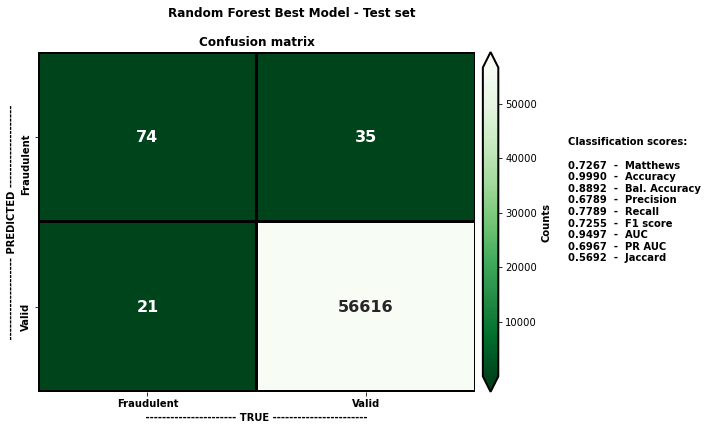

In [55]:
# Keep results.
models[model_code] = search.best_estimator_
results[model_code] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test,
    model_name="Random Forest Best Model - Test set"
)

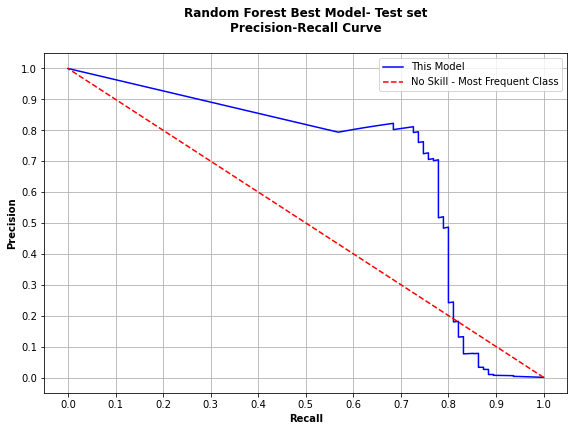

In [56]:
# Show results for test set.
plot_pr_roc(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test,
    model_name="Random Forest Best Model- Test set"
)

CPU times: user 7.31 s, sys: 288 ms, total: 7.6 s
Wall time: 7.03 s


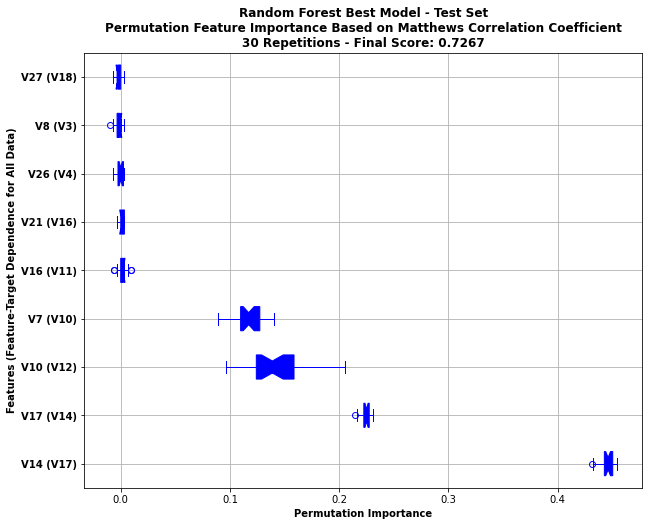

In [57]:
%%time

# Importance of features in test set.
n_repeats = 30
PI = permutation_importance(
    estimator=search.best_estimator_,
    X=df_X_test[used_features],
    y=df_y_test,
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_repeats=n_repeats,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
PI = PI.importances[order, :]
used_features_ordered = np.array(used_features)[order]

# Make figure.
plt.figure(figsize=(10, 8))
plt.boxplot(
    notch=True,
    x=PI.T,
    vert=False,
    labels=used_features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)

# Adjustments.
ax = plt.gca()
ax.set_xlabel("Permutation Importance", weight="bold")
ax.set_ylabel("Features (Feature-Target Dependence for All Data)", weight="bold")
ax.set_title("Random Forest Best Model - Test Set\n" + \
             "Permutation Feature Importance Based on Matthews Correlation Coefficient\n" + \
             f"{n_repeats} Repetitions - Final Score: {results[model_code][0]:.4f}", 
             weight="bold")
ax.grid()
p1 = used_features_ordered
p2 = mi_ordered.index.drop("Time")[::-1]
yticklabels = [v1 + " (" + v2 + ")" for v1, v2 in zip(p1, p2)]
_ = ax.set_yticklabels(yticklabels, weight="bold")

## Random Forest (All Features)

In [58]:
%%time

# Used in dictionary with results.
model_code = "ranfor2"

# Input features for this model.
used_features = df_X_train.columns

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("model", XGBRFClassifier())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={
        "model__n_estimators": [100, 200],
        "model__max_depth": [5],
        "model__scale_pos_weight": [100, 600],
        "model__learning_rate": [0.075, 0.10],
        "model__reg_alpha": [0.1, 1],
        "model__reg_lambda": [0.1, 1]
    },
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train[used_features], df_y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 12.9min finished


CPU times: user 9min 16s, sys: 11.1 s, total: 9min 27s
Wall time: 13min 7s


In [59]:
# Number of tested models.
n_candidates = len(search.cv_results_["params"])

# Number of used features.
n_features = search.n_features_in_

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df_tmp = pd.DataFrame(search.cv_results_)
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                                              268.307
std_fit_time                                                               2.73578
mean_score_time                                                           0.547044
std_score_time                                                           0.0147733
param_model__learning_rate                                                   0.075
param_model__max_depth                                                           5
param_model__n_estimators                                                      200
param_model__reg_alpha                                                           1
param_model__reg_lambda                                                          1
param_model__scale_pos_weight                                                  100
params                           {'model__learning_rate': 0.075, 'model__max_de...
split0_test_score                              

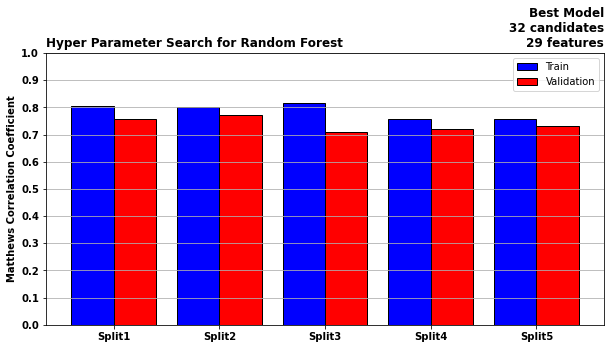

In [60]:
# Train and validation scores for optimum hyper parameter set.
train_cols = [col for col in df_tmp.columns if ("split" in col) and ("train" in col)]
validation_cols = [col for col in df_tmp.columns if ("split" in col) and ("test" in col)]
x = np.arange(1, search.cv.n_splits + 1)
df_tmp = pd.DataFrame(
    data=np.column_stack((
        x,
        df_tmp.iloc[search.best_index_].loc[train_cols], 
        df_tmp.iloc[search.best_index_].loc[validation_cols]
    )),
    columns=["Split", "Train", "Validation"]
)

# Make figure.
plt.figure(figsize=(10, 5))
plt.bar(x - 0.40, df_tmp.Train, width=0.40, color="blue", label="Train", align="edge",
        edgecolor="black")
plt.bar(x, df_tmp.Validation, width=0.40, color="red", label="Validation", align="edge",
        edgecolor="black")
plt.legend()
plt.ylim((0, 1))
plt.yticks(np.arange(0, 1.1, 0.1), weight="bold")
plt.grid(axis="y")
plt.gca().set_xticklabels([""] + ["Split" + str(num) for num in x], weight="bold")
plt.ylabel("Matthews Correlation Coefficient", weight="bold")
plt.title("Hyper Parameter Search for Random Forest", weight="bold", loc="left")
_ = plt.title(f"Best Model\n{n_candidates} candidates\n{n_features} features", 
          weight="bold", loc="right")

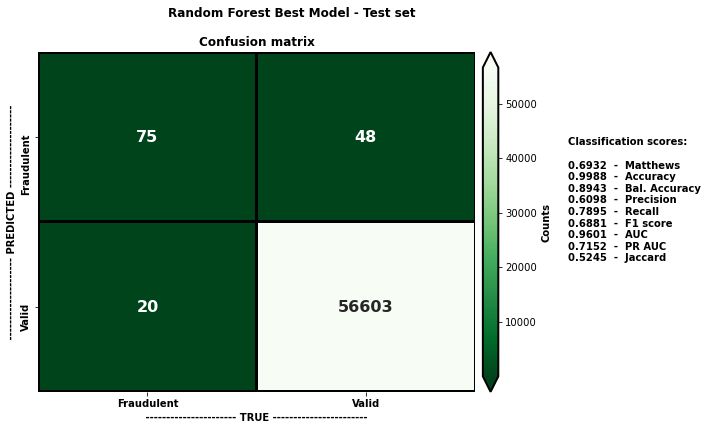

In [61]:
# Keep results.
models[model_code] = search.best_estimator_
results[model_code] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test,
    model_name="Random Forest Best Model - Test set"
)

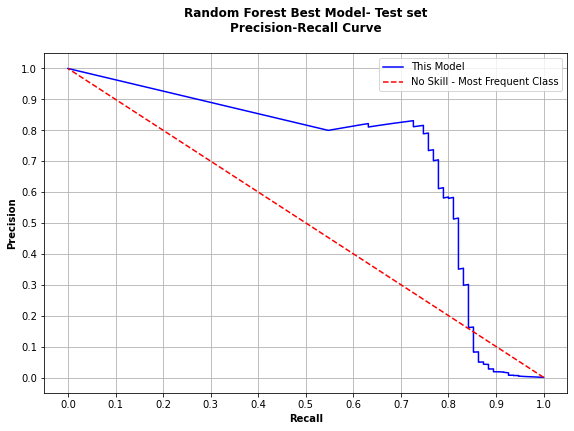

In [62]:
# Show results for test set.
plot_pr_roc(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test,
    model_name="Random Forest Best Model- Test set"
)

CPU times: user 7.9 s, sys: 408 ms, total: 8.31 s
Wall time: 21 s


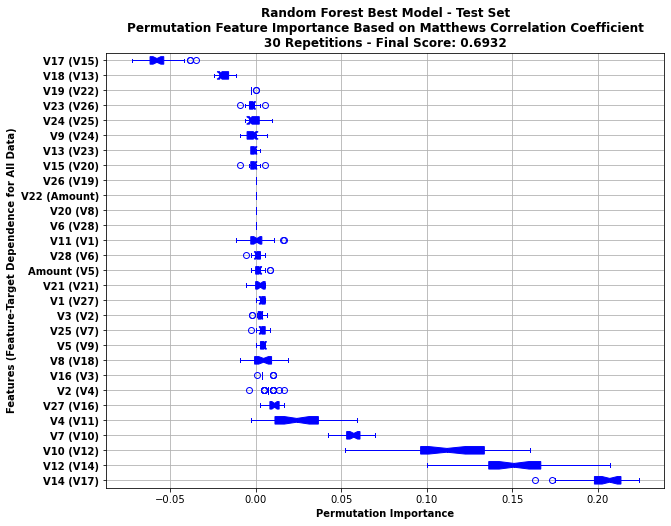

In [63]:
%%time

# Importance of features in test set.
n_repeats = 30
PI = permutation_importance(
    estimator=search.best_estimator_,
    X=df_X_test[used_features],
    y=df_y_test,
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_repeats=n_repeats,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
PI = PI.importances[order, :]
used_features_ordered = np.array(used_features)[order]

# Make figure.
plt.figure(figsize=(10, 8))
plt.boxplot(
    notch=True,
    x=PI.T,
    vert=False,
    labels=used_features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)

# Adjustments.
ax = plt.gca()
ax.set_xlabel("Permutation Importance", weight="bold")
ax.set_ylabel("Features (Feature-Target Dependence for All Data)", weight="bold")
ax.set_title("Random Forest Best Model - Test Set\n" + \
             "Permutation Feature Importance Based on Matthews Correlation Coefficient\n" + \
             f"{n_repeats} Repetitions - Final Score: {results[model_code][0]:.4f}", 
             weight="bold")
ax.grid()
p1 = used_features_ordered
p2 = mi_ordered.index.drop("Time")[::-1]
yticklabels = [v1 + " (" + v2 + ")" for v1, v2 in zip(p1, p2)]
_ = ax.set_yticklabels(yticklabels, weight="bold")

## Conclusions

In [64]:
%%time

# Head of table with all results.
final_table = PrettyTable(
    field_names=[
        "Tuned Model", 
        "Matt.",
        "Acc.",
        "Bal. Acc.",
        "Precision",
        "Recall",
        "F1 Score",
        "AUC",
        "PR AUC",
        "Jaccard"
    ], 
    title="Overall Performances of Machine Learning Models on Test Data"
)
final_table.align = "l"

# Fill this table with performances of trained models.
final_table.add_row(
    ["Dummy Classifier"] + \
    ["%.4f" %(m) for m in results["dummy"]]
)
final_table.add_row(
    ["KNN Classifier"] + \
    ["%.4f" %(m) for m in results["knncla"]]
)
final_table.add_row(
    ["Logistic Regression"] + \
    ["%.4f" %(m) for m in results["logreg"]]
)
final_table.add_row(
    ["ML Perceptron"] + \
    ["%.4f" %(m) for m in results["mlpcla"]]
)
final_table.add_row(
    ["Decision Tree"] + \
    ["%.4f" %(m) for m in results["dectre"]]
)
final_table.add_row(
    ["XGBoost Classifier"] + \
    ["%.4f" %(m) for m in results["xgboos"]]
)
final_table.add_row(
    ["Random Forest"] + \
    ["%.4f" %(m) for m in results["ranfor"]]
)
final_table.add_row(
    ["Random Forest (All)"] + \
    ["%.4f" %(m) for m in results["ranfor2"]]
)

# Save PrettyTable results to a CSV file.
filename = "results.csv"
ptable_to_csv(table=final_table, filename=filename, headers=True)

# Read it as a data frame.
df_results = pd.read_csv(filepath_or_buffer=filename, index_col=0)

print(final_table)

+---------------------------------------------------------------------------------------------------------------+
|                          Overall Performances of Machine Learning Models on Test Data                         |
+---------------------+--------+--------+-----------+-----------+--------+----------+--------+--------+---------+
| Tuned Model         | Matt.  | Acc.   | Bal. Acc. | Precision | Recall | F1 Score | AUC    | PR AUC | Jaccard |
+---------------------+--------+--------+-----------+-----------+--------+----------+--------+--------+---------+
| Dummy Classifier    | 0.0000 | 0.9983 | 0.5000    | 0.0000    | 0.0000 | 0.0000   | 0.5000 | 0.5008 | 0.0000  |
| KNN Classifier      | 0.4879 | 0.9986 | 0.6788    | 0.6667    | 0.3579 | 0.4658   | 0.7256 | 0.4343 | 0.3036  |
| Logistic Regression | 0.7630 | 0.9993 | 0.8368    | 0.8649    | 0.6737 | 0.7574   | 0.9745 | 0.7280 | 0.6095  |
| ML Perceptron       | 0.7852 | 0.9993 | 0.8736    | 0.8256    | 0.7474 | 0.7845   | 0.

CPU times: user 324 ms, sys: 8 ms, total: 332 ms
Wall time: 330 ms


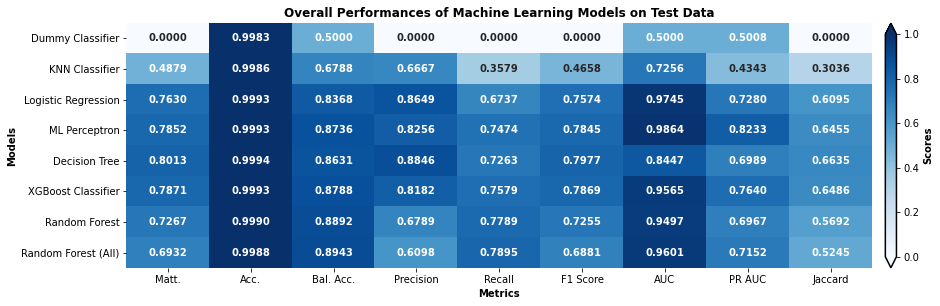

In [65]:
%%time

plt.figure(figsize=(16, 4.5))
ax = sns.heatmap(
    data=df_results, 
    cmap=plt.cm.Blues, 
    vmin=0.00, 
    vmax=1.00,
    annot=True,
    fmt=".4f",
    annot_kws={"weight": "bold", "size": 10},
    cbar_kws={"extend": "both", "pad": 0.015},
)
ax.set_title("Overall Performances of Machine Learning Models on Test Data", 
             weight="bold")
ax.set_xlabel("Metrics", weight="bold")
ax.set_ylabel("Models", weight="bold")
ax.collections[0].colorbar.outline.set_edgecolor("black")
ax.collections[0].colorbar.outline.set_linewidth(1.5)
ax.collections[0].colorbar.set_label(f"Scores", weight="bold")

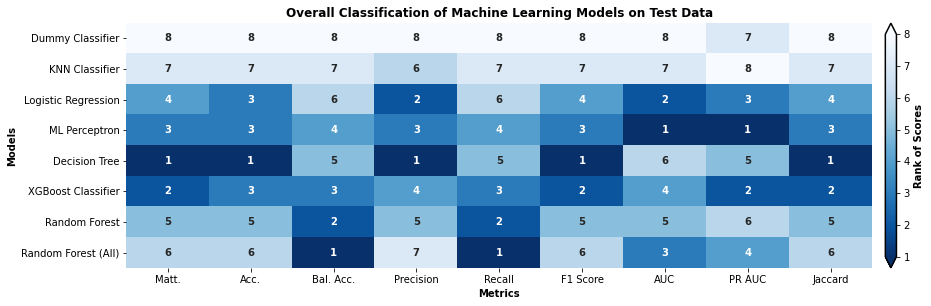

In [66]:
df_results_ranks = pd.DataFrame(
    data=scipy.stats.rankdata((-1) * df_results, axis=0),
    index=df_results.index,
    columns=df_results.columns
)

plt.figure(figsize=(16, 4.5))
ax = sns.heatmap(
    data=df_results_ranks, 
    cmap=plt.cm.Blues_r, 
    annot=True,
    annot_kws={"weight": "bold", "size": 10},
    cbar_kws={"extend": "both", "pad": 0.015},
)
ax.set_title("Overall Classification of Machine Learning Models on Test Data", 
             weight="bold")
ax.set_xlabel("Metrics", weight="bold")
ax.set_ylabel("Models", weight="bold")
ax.collections[0].colorbar.outline.set_edgecolor("black")
ax.collections[0].colorbar.outline.set_linewidth(1.5)
ax.collections[0].colorbar.set_label(f"Rank of Scores", weight="bold")